# <font color="Blue"> Capstone project 
##    **Ha Luong** 
###   _September 2023_ <font>

<a id="home"></a>
- [Data Description](#data_description)
- [Data Cleaning](#data_cleaning)
- [EDA](#eda)
- [Correlation Analysis](#correlation_analysis)
- [Sales forecast](#Sales_forecast)
    - [Trend and seasonal analysis](#Trend_and_seasonal_analysis)
    - [ARIMA and SARIMA models](#ARIMA_SARIMA_models)
        - [Forecast daily sale](#Forecast_daily_sale)
        - [Forecast daily sale of each shopping mall](#Forecast_daily_sale_of_each_shopping_mall)
        - [Forecast_weeky_sales](#Forecast_weeky_sales_using_ARIMA_and_SARIMA_models)
    - [XGboost model](#XGboost_model)
        - [Forecast daily sale](#Forecast_the_whole_dateset_daily_sales)
        - [Forecast daily sale for each shopping mall](#XGboost_Forecast_for_each_shopping_mall)

#### [Home](#home)

<a id="data_description"></a>
## Data description

**The dataset contains shopping information from 10 different shopping malls between 2021 and 2023.**

**Attribute Information:**
- invoice_no: Invoice number. Nominal. A combination of the letter 'I' and a 6-digit integer uniquely assigned to each operation.
- customer_id: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each operation.
- gender: String variable of the customer's gender.
- age: Positive Integer variable of the customers age.
- category: String variable of the category of the purchased product.
- quantity: The quantities of each product (item) per transaction. Numeric.
- price: Unit price. Numeric. Product price per unit in Turkish Liras (TL).
- payment_method: String variable of the payment method (cash, credit card or debit card) used for the transaction.
- invoice_date: Invoice date. The day when a transaction was generated.
- shopping_mall: String variable of the name of the shopping mall where the transaction was made.

The Dataset can be accesed on: 
https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

Data visualization can be found at: 


In [1]:
# Import the libraries we will need

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Read the data
df = pd.read_csv('customer_shopping_data.csv')
df.tail()

invoice_no customer_id  gender  age         category  quantity    price  \
99452    I219422     C441542  Female   45         Souvenir         5    58.65   
99453    I325143     C569580    Male   27  Food & Beverage         2    10.46   
99454    I824010     C103292    Male   63  Food & Beverage         2    10.46   
99455    I702964     C800631    Male   56       Technology         4  4200.00   
99456    I232867     C273973  Female   36         Souvenir         3    35.19   

      payment_method invoice_date     shopping_mall  
99452    Credit Card   21/09/2022            Kanyon  
99453           Cash   22/09/2021    Forum Istanbul  
99454     Debit Card   28/03/2021         Metrocity  
99455           Cash   16/03/2021      Istinye Park  
99456    Credit Card   15/10/2022  Mall of Istanbul

In [3]:
df.shape

(99457, 10)

In [4]:
df.dtypes

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object

In [5]:
df.index

RangeIndex(start=0, stop=99457, step=1)

#### [Home](#home)

<a id="data_cleaning"></a>
## Data cleaning

In [6]:
# convert invoice_date to date type
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y', errors='coerce')
df.dtypes

invoice_no                object
customer_id               object
gender                    object
age                        int64
category                  object
quantity                   int64
price                    float64
payment_method            object
invoice_date      datetime64[ns]
shopping_mall             object
dtype: object

In [7]:
# Create a sales column = quantity * price
df['sales'] = (df['quantity'] * df['price']).astype(float)
df = df.sort_values(by='invoice_date')
df.tail()

invoice_no customer_id  gender  age         category  quantity    price  \
20863    I218048     C389917  Female   66         Clothing         5  1500.40   
20879    I268432     C175797  Female   37  Food & Beverage         3    15.69   
61644    I200744     C224026  Female   59        Cosmetics         5   203.30   
27871    I124836     C265661  Female   46            Shoes         3  1800.51   
60463    I154677     C188068  Female   49        Cosmetics         1    40.66   

      payment_method invoice_date     shopping_mall    sales  
20863           Cash   2023-03-08  Mall of Istanbul  7502.00  
20879           Cash   2023-03-08            Kanyon    47.07  
61644    Credit Card   2023-03-08            Kanyon  1016.50  
27871    Credit Card   2023-03-08         Metrocity  5401.53  
60463           Cash   2023-03-08            Kanyon    40.66

In [8]:
df.describe()

age      quantity         price         sales
count  99457.000000  99457.000000  99457.000000  99457.000000
mean      43.427089      3.003429    689.256321   2528.789268
std       14.990054      1.413025    941.184567   4222.475781
min       18.000000      1.000000      5.230000      5.230000
25%       30.000000      2.000000     45.450000    136.350000
50%       43.000000      3.000000    203.300000    600.170000
75%       56.000000      4.000000   1200.320000   2700.720000
max       69.000000      5.000000   5250.000000  26250.000000

_Note: From the statistics, there seem to be no obvious outliners._

####  <font style='color: green'> Check for null and duplicate </font>

In [9]:
# Check for null values in all columns
null_values = df.isnull().sum()
print(null_values)

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
sales             0
dtype: int64


_Note: No missing data found in the dataset_

In [10]:
print(df['shopping_mall'].unique())

['Metrocity' 'Mall of Istanbul' 'Istinye Park' 'Kanyon'
 'Emaar Square Mall' 'Viaport Outlet' 'Cevahir AVM' 'Metropol AVM'
 'Forum Istanbul' 'Zorlu Center']


In [11]:
# Check for and display duplicate rows
duplicate_rows = df[df.duplicated()]

# To count the number of duplicate rows
print(len(duplicate_rows))

0


_Note: No duplicate found in the dataset_

####  <font style='color: green'> Adding location data for shopping malls </font>

In [12]:
# Find the longtitute and lattitute for the shopping malls to make data visualization
!pip install geopy
from geopy.geocoders import Nominatim

# Initialize the geocoder
geolocator = Nominatim(user_agent="shopping_mall_locator")

# List of shopping malls
shopping_malls = [
    'Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM', 'Istinye Park',
    'Mall of Istanbul', 'Emaar Square Mall', 'Cevahir AVM', 'Viaport Outlet',
    'Zorlu Center'
]

# Dictionary to store the results
mall_coordinates = {
    "Mall": [],
    "Latitude": [],
    "Longitude": []
}

# Iterate through the shopping malls and get their coordinates
for mall in shopping_malls:
    location = geolocator.geocode(mall + ', Istanbul, Turkey')
    if location:
        mall_coordinates["Mall"].append(mall)
        mall_coordinates["Latitude"].append(location.latitude)
        mall_coordinates["Longitude"].append(location.longitude)
    else:
        mall_coordinates["Mall"].append(mall)
        mall_coordinates["Latitude"].append("Not found")
        mall_coordinates["Longitude"].append("Not found")

# Create a DataFrame from the dictionary
df_mall = pd.DataFrame(mall_coordinates)

# Save the DataFrame to a CSV file
df_mall.to_csv('shopping_malls_coordinates.csv', index=False)

# Print the results
print(df_mall)

                Mall   Latitude  Longitude
0             Kanyon  41.078172  29.010814
1     Forum Istanbul  41.047938  28.897856
2          Metrocity  41.076048  29.011806
3       Metropol AVM  40.994175  29.121846
4       Istinye Park  40.963024  29.256163
5   Mall of Istanbul  41.063253  28.806974
6  Emaar Square Mall  41.003329  29.071126
7        Cevahir AVM  41.075831  28.945169
8     Viaport Outlet  40.939380  29.324177
9       Zorlu Center  41.066448  29.017788


####  <font style='color: green'> Check for competeness and accuracy of records in 3 years <font>

In [13]:
# Create year, month, day of week column from invoice_date
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day_of_week'] = df['invoice_date'].dt.day_name()

In [14]:
# Chech for distribution of transaction by shopping mall and year
# Group by 'year' and 'shopping_mall' and count occurrences
grouped_df = df.groupby(['year', 'shopping_mall']).size().reset_index(name='count')

# Sort value counts within each year in descending order
grouped_df['rank'] = grouped_df.groupby('year')['count'].rank(ascending=False, method='first')
sorted_df = grouped_df.sort_values(['year', 'rank'])

# Create a bar graph using Plotly Express
fig = px.bar(sorted_df, x='year', y='count', color='shopping_mall', title='Number of Transaction per Year and shopping mall')
fig.update_xaxes(type='category')

# Show the graph
fig.show()

In [15]:
# Find the minimum and maximum values in the 'invoice_date' column
print(df['invoice_date'].min())
print(df['invoice_date'].max())

2021-01-01 00:00:00
2023-03-08 00:00:00


Note: There are only 67 days recorded in 2023, while there are 365 days for 2021 and 2022. Records for 2023 is only up to 8th March.

#### [Home](#home)

<a id="eda"></a>
## EDA

###  <font style='color: blue'> Distribution of age, price and quantity

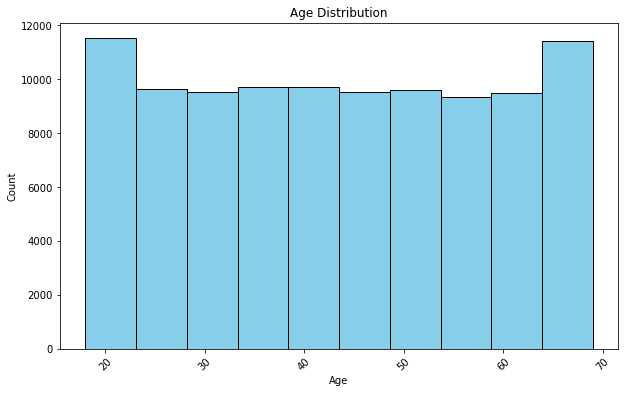

In [16]:
# Create a histogram for age
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()

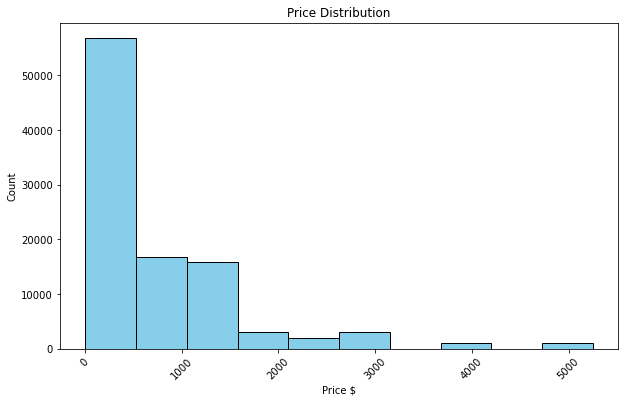

In [17]:
# Create a histogram for price
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Price $')
plt.ylabel('Count')
plt.title('Price Distribution')
plt.xticks(rotation=45)
plt.show()

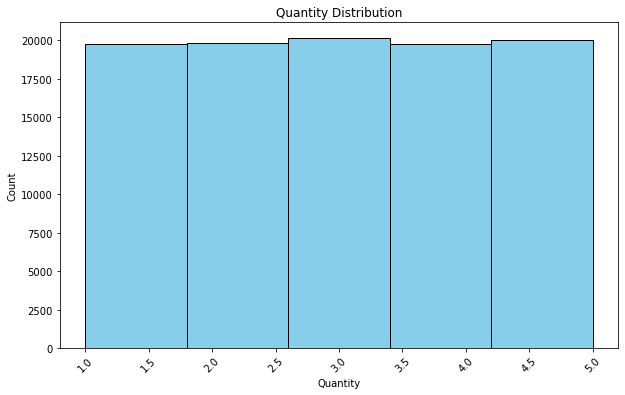

In [18]:
# Create a histogram for age
plt.figure(figsize=(10, 6))
plt.hist(df['quantity'], bins=5, color='skyblue', edgecolor='black')
plt.xlabel('Quantity')
plt.ylabel('Count')
plt.title('Quantity Distribution')
plt.xticks(rotation=45)
plt.show()

### Number of transaction by category

In [19]:
df['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: category, dtype: int64

### Number of transaction by gender

In [20]:
df['gender'].value_counts()

Female    59482
Male      39975
Name: gender, dtype: int64

####  <font style='color: green'> Total sales analysis by shopping mall, by time of transaction <font>

<font color='green'> Number of transaction by shopping mall <font>

In [21]:
# Get the value counts of 'shopping_mall'
mall_counts = df['shopping_mall'].value_counts().reset_index()

# Rename columns
mall_counts.columns = ['Shopping Mall', 'Total transactions']

# Calculate the percentage of each shopping mall
mall_counts['Percentage'] = (mall_counts['Total transactions'] / mall_counts['Total transactions'].sum()) * 100

# Display the result
print(mall_counts)

       Shopping Mall  Total transactions  Percentage
0   Mall of Istanbul               19943   20.051882
1             Kanyon               19823   19.931227
2          Metrocity               15011   15.092955
3       Metropol AVM               10161   10.216475
4       Istinye Park                9781    9.834401
5       Zorlu Center                5075    5.102708
6        Cevahir AVM                4991    5.018249
7     Forum Istanbul                4947    4.974009
8     Viaport Outlet                4914    4.940829
9  Emaar Square Mall                4811    4.837266


In [22]:
# Number of transaction by shopping mall and by year
df.groupby('year')['shopping_mall'].value_counts()

year  shopping_mall    
2021  Mall of Istanbul     9026
      Kanyon               8946
      Metrocity            6856
      Metropol AVM         4679
      Istinye Park         4419
      Cevahir AVM          2365
      Zorlu Center         2330
      Viaport Outlet       2286
      Forum Istanbul       2253
      Emaar Square Mall    2222
2022  Mall of Istanbul     9202
      Kanyon               9153
      Metrocity            6890
      Metropol AVM         4613
      Istinye Park         4521
      Forum Istanbul       2281
      Zorlu Center         2281
      Cevahir AVM          2231
      Viaport Outlet       2220
      Emaar Square Mall    2159
2023  Kanyon               1724
      Mall of Istanbul     1715
      Metrocity            1265
      Metropol AVM          869
      Istinye Park          841
      Zorlu Center          464
      Emaar Square Mall     430
      Forum Istanbul        413
      Viaport Outlet        408
      Cevahir AVM           395
Name: shopping_m

_Note: The ranking of shopping mall by total number of transaction remain the same from 2021-2022_

<font color='green'> Number of transaction by year, month and day of week <font>

In [23]:
# Group by month and count transactions
monthly_counts = df.groupby(df['invoice_date'].dt.to_period('M')).size().reset_index()
monthly_counts.columns = ['Month', 'Number of Transactions']

# Convert the 'Month' column to a string representation
monthly_counts['Month'] = monthly_counts['Month'].dt.strftime('%Y-%m')

# Create an interactive bar graph using Plotly Express
fig = px.bar(
    monthly_counts,
    x='Month',
    y='Number of Transactions',
    title='Number of Transactions by Invoice date',
    labels={'Number of Transactions': 'Number of Transactions'},
)

# Customize the appearance of the plot if needed
fig.update_xaxes(type='category')
fig.update_layout(xaxis_tickangle=-45, showlegend=False)

# Show the interactive plot
fig.show()

###  <font style='color: blue'>  Total sales analysis

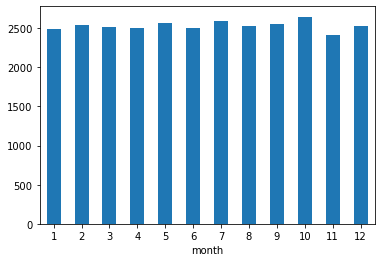

In [24]:
df.groupby('month')['sales'].mean().plot.bar(rot=0);

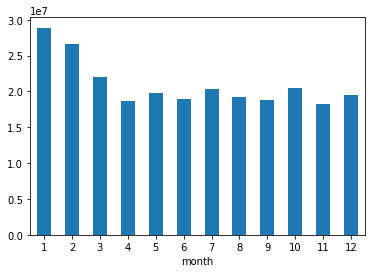

In [25]:
df.groupby('month')['sales'].sum().plot.bar(rot=0);

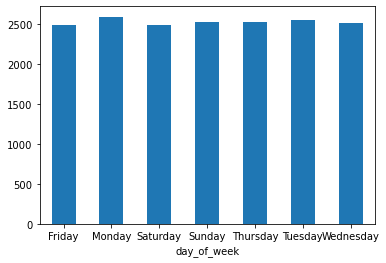

In [26]:
df.groupby('day_of_week')['sales'].mean().plot.bar(rot=0);

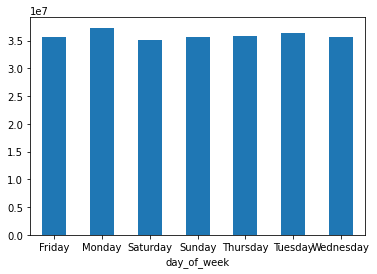

In [27]:
df.groupby('day_of_week')['sales'].sum().plot.bar(rot=0);

#### [Home](#home)

<a id="correlation_analysis"></a>
## Correlation analysis

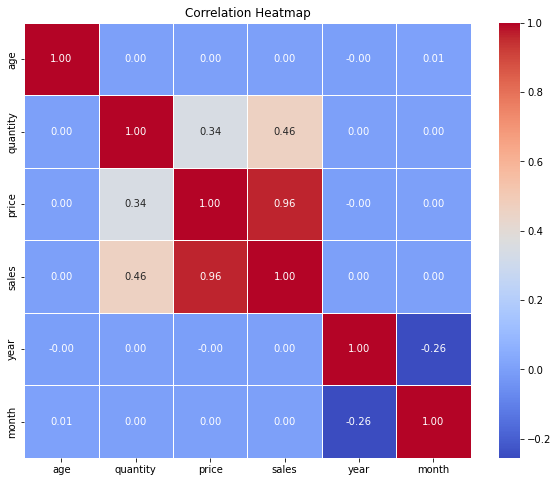

In [28]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

#### [Home](#home)

<a id="Sales_forecast"></a>
## Sales Forecast

<a id="Trend_and_seasonal_analysis"></a>
### <font style='color: green'> Trend and seasonal analysis

#### <font style='color: green'> Create daily and weekly data to look for trend and seasonality 

In [60]:
# Create daily_sales dataframe
total_daily_sales = df.groupby(['invoice_date'])['sales'].sum().reset_index()
total_daily_sales.head()

invoice_date      sales
0   2021-01-01  271192.66
1   2021-01-02  303659.14
2   2021-01-03  375794.99
3   2021-01-04  284512.26
4   2021-01-05  308395.08

In [61]:
# Convert the entire DataFrame to float
total_daily_sales = total_daily_sales.astype({'sales': float})
# Ensure that the 'invoice_date' column is a datetime index
total_daily_sales.set_index('invoice_date', inplace=True)

In [62]:
total_daily_sales.shape

(797, 1)

In [63]:
print(total_daily_sales.index.nunique())

797


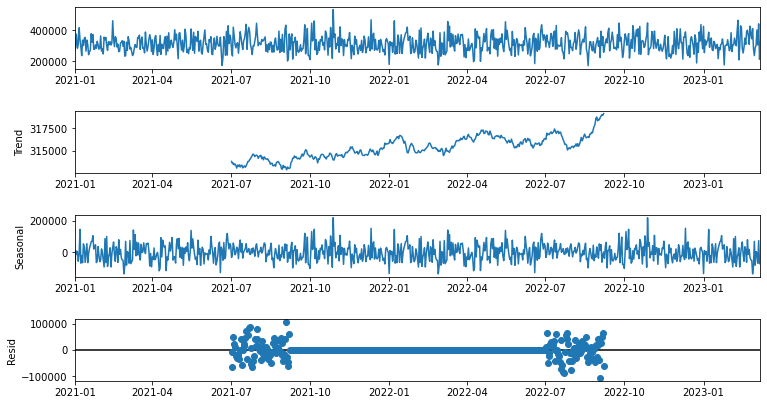

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Drop rows with missing values
total_daily_sales = total_daily_sales.dropna()

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_daily_sales, period=365)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 6)

plt.show()


Unclear overall trend and limited seasonality patterns are observed in the data.

In [65]:
# Group sales by 'week' and sum the sales values
weekly_sales =  df.groupby([pd.Grouper(key='invoice_date', freq='W')])['sales'].sum().reset_index()

invoice_date       sales
0   2021-01-03   950646.79
1   2021-01-10  2219120.13
2   2021-01-17  2157950.55
3   2021-01-24  2162023.56
4   2021-01-31  2151873.59

<AxesSubplot:xlabel='invoice_date'>

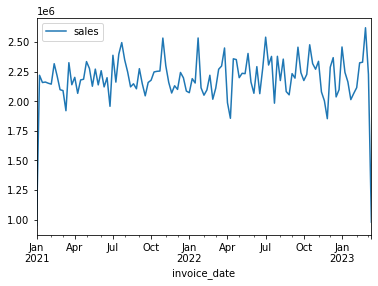

In [67]:
# Set the index to be the `invoice_date`
weekly_sales.set_index("invoice_date", inplace=True)
weekly_sales.plot()

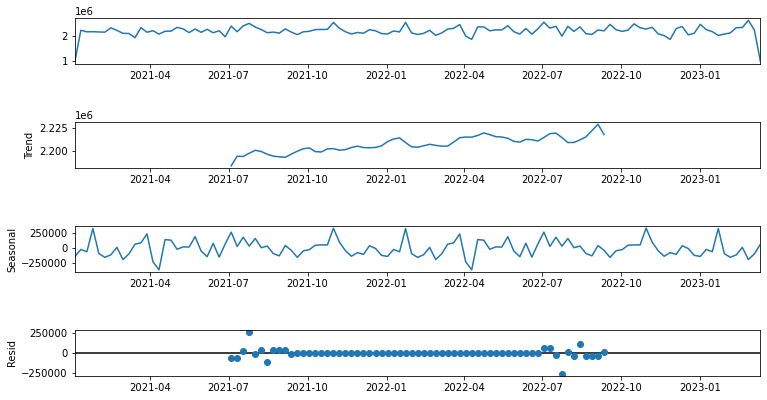

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(weekly_sales, period=52)
fig = decomposition.plot()
fig.set_size_inches(12, 6)

plt.show()

<a id="ARIMA_SARIMA_models"></a>
### <font style='color: green'> ARIMA and SARIMA models

In [69]:
# Split the dataset into training and test sets
train = total_daily_sales["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test = total_daily_sales["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model = ARIMA(train, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred = model.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal = seasonal_model.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error = mean_squared_error(test, y_pred) ** 0.5
sarima_error = mean_squared_error(test, y_pred_seasonal) ** 0.5

print('ARIMA error:', arima_error)
print('SARIMA error:', sarima_error)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29000D+01    |proj g|=  2.20074D-01

At iterate    5    f=  1.24089D+01    |proj g|=  5.10644D-02

At iterate   10    f=  1.23703D+01    |proj g|=  2.44094D-03

At iterate   15    f=  1.23678D+01    |proj g|=  4.36932D-02

At iterate   20    f=  1.23524D+01    |proj g|=  1.39236D-02

At iterate   25    f=  1.23499D+01    |proj g|=  9.54043D-03

At iterate   30    f=  1.23471D+01    |proj g|=  5.18022D-03

At iterate   35    f=  1.23463D+01    |proj g|=  3.36646D-03

At iterate   40    f=  1.23462D+01    |proj g|=  7.36853D-04

At iterate   45    f=  1.23455D+01    |proj g|=  3.76156D-04


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.23271D+01    |proj g|=  1.14048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     78      1     0     0   1.140D-02   1.233D+01
  F =   12.327141093862071     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA error: 58446.57566095756
SARIMA error: 58473.28382071255


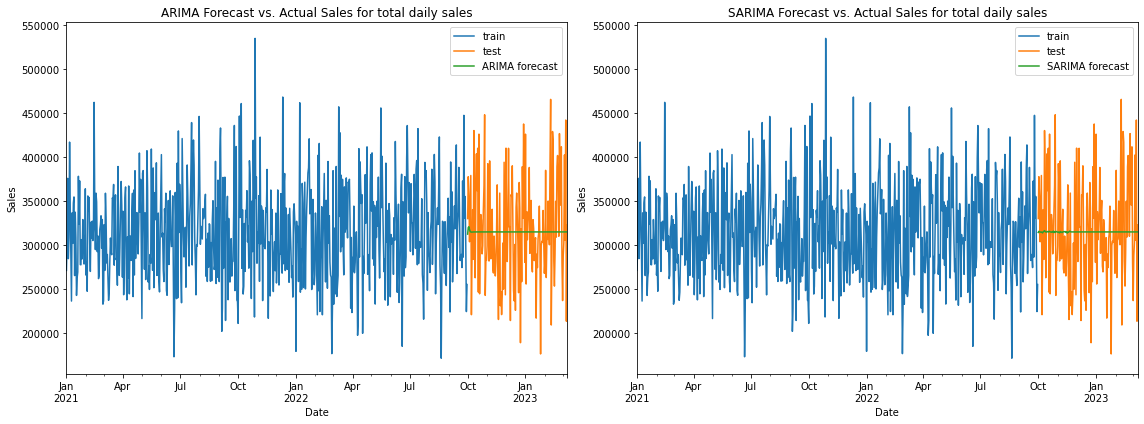

In [70]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train['sales'].plot(ax=ax1, label="train")
test['sales'].plot(ax=ax1, label="test")
y_pred.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for total daily sales")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train['sales'].plot(ax=ax2, label="train")
test['sales'].plot(ax=ax2, label="test")
y_pred_seasonal.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for total daily sales")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

<a id="Forecast_daily_sale_of_each_shopping_mall"></a>
#### <font style='color: green'> Forecast daily sale of each shopping mall using ARIMA and SARIMA models

Create daily sales of 10 shopping mall

In [71]:
# Create daily_sales dataframe
daily_sales = df.groupby(['invoice_date', 'shopping_mall'])['sales'].sum().reset_index()
daily_sales.head()

invoice_date      shopping_mall     sales
0   2021-01-01        Cevahir AVM   3332.96
1   2021-01-01  Emaar Square Mall  25438.83
2   2021-01-01     Forum Istanbul   4522.56
3   2021-01-01       Istinye Park  16618.68
4   2021-01-01             Kanyon  58495.73

In [72]:
daily_sales['shopping_mall'].value_counts()

Emaar Square Mall    797
Istinye Park         797
Kanyon               797
Mall of Istanbul     797
Metrocity            797
Metropol AVM         797
Cevahir AVM          796
Viaport Outlet       796
Forum Istanbul       795
Zorlu Center         794
Name: shopping_mall, dtype: int64

_Note: 4 shopping mall missing some days during the time period. It's neccessary to identify the missing day to run time series model. Those malls are: Cevahir AVM, Viaport Outlet, Forum Istanbul and Zorlu Center._

In [73]:
# Create daily sales for each shopping mall
Emaar_Square_Mall = daily_sales[daily_sales['shopping_mall'] == "Emaar Square Mall"].drop(columns=['shopping_mall'])
Kanyon = daily_sales[daily_sales['shopping_mall'] == "Kanyon"].drop(columns=['shopping_mall'])
MoI = daily_sales[daily_sales['shopping_mall'] == "Mall of Istanbul"].drop(columns=['shopping_mall'])
Metrocity = daily_sales[daily_sales['shopping_mall'] == "Metrocity"].drop(columns=['shopping_mall'])
Metropol_AVM = daily_sales[daily_sales['shopping_mall'] == "Metropol AVM"].drop(columns=['shopping_mall'])
Istinye_Park = daily_sales[daily_sales['shopping_mall'] == "Istinye Park"].drop(columns=['shopping_mall'])
Zorlu_Center = daily_sales[daily_sales['shopping_mall'] == "Zorlu Center"].drop(columns=['shopping_mall'])
Forum_Istanbul = daily_sales[daily_sales['shopping_mall'] == "Forum Istanbul"].drop(columns=['shopping_mall'])
Viaport_Outlet = daily_sales[daily_sales['shopping_mall'] == "Viaport Outlet"].drop(columns=['shopping_mall'])
Cevahir_AVM = daily_sales[daily_sales['shopping_mall'] == "Cevahir AVM"].drop(columns=['shopping_mall'])

In [74]:
Zorlu_Center.head()

invoice_date     sales
9    2021-01-01  22037.89
19   2021-01-02  12782.65
29   2021-01-03  19805.44
39   2021-01-04  22864.80
49   2021-01-05    655.79

In [75]:
file_names = {
    'Emaar_Square_Mall': Emaar_Square_Mall,
    'Istinye_Park': Istinye_Park,
    'Kanyon': Kanyon,
    'MoI': MoI,
    'Metrocity': Metrocity,
    'Metropol_AVM': Metropol_AVM,
    'Zorlu_Center': Zorlu_Center,
    'Forum_Istanbul': Forum_Istanbul,
    'Viaport_Outlet': Viaport_Outlet,
    'Cevahir_AVM': Cevahir_AVM
}

# Loop through the DataFrames and save them as CSV files
for mall_name, df in file_names.items():
    df.to_csv(f"{mall_name}.csv", index=False)

In [76]:
Emaar_Square_Mall.tail()

invoice_date     sales
7914   2023-03-04  18003.08
7924   2023-03-05  31831.75
7934   2023-03-06  24794.59
7944   2023-03-07   6656.33
7954   2023-03-08  13496.92

####  <font style='color: green'> Forecast daily sales using ARIMA model <font>

* Forecast daily sales for Emaar Square Mall

In [77]:
# Convert the entire DataFrame to float
Emaar_Square_Mall = Emaar_Square_Mall.astype({'sales': float})

# Ensure that the 'invoice_date' column is a datetime index
Emaar_Square_Mall.set_index('invoice_date', inplace=True)

# Split the dataset into training and test sets
train1 = Emaar_Square_Mall["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test1 = Emaar_Square_Mall["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

train1.head()

sales
invoice_date          
2021-01-01    25438.83
2021-01-02     3943.91
2021-01-03     9024.88
2021-01-04     8420.53
2021-01-05     5767.47

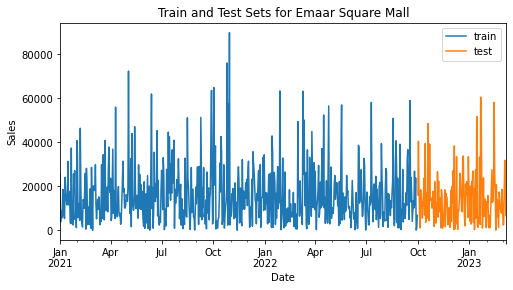

In [78]:
# Plot train and test set
fig, ax = plt.subplots(figsize=(8, 4))

train1['sales'].plot(ax=ax, label="train")
test1['sales'].plot(ax=ax, label="test")

ax.legend()
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Train and Test Sets for Emaar Square Mall")

plt.show()

In [79]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(train1, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_1 = model1.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



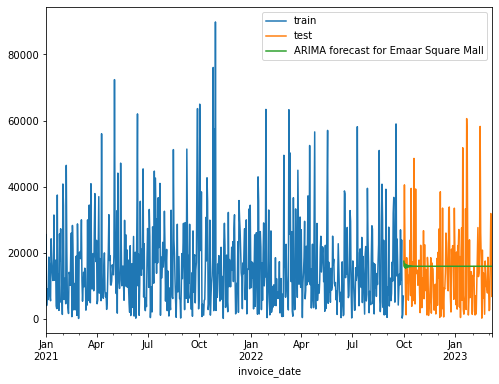

In [80]:
# Plot the dataset and forecast result
fig, ax = plt.subplots(figsize=(8, 6))

train1['sales'].plot(ax=ax, label="train")
test1['sales'].plot(ax=ax, label="test")
y_pred_1.plot(ax=ax, label="ARIMA forecast for Emaar Square Mall")
ax.legend()

plt.show()

####  <font style='color: green'> Forecast daily sales using SARIMA model <font> 

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_model_1 = SARIMAX(train1, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_1 = seasonal_model_1.predict(start="2022-10-01", end="2023-03-08")

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11435D+01    |proj g|=  2.89912D-01

At iterate    5    f=  1.09530D+01    |proj g|=  9.25428D-03

At iterate   10    f=  1.09323D+01    |proj g|=  7.80868D-03

At iterate   15    f=  1.09249D+01    |proj g|=  4.18954D-03

At iterate   20    f=  1.09193D+01    |proj g|=  1.26004D-02

At iterate   25    f=  1.09182D+01    |proj g|=  5.93327D-04

At iterate   30    f=  1.09179D+01    |proj g|=  4.05393D-05

At iterate   35    f=  1.09179D+01    |proj g|=  2.77808D-05

At iterate   40    f=  1.09178D+01    |proj g|=  2.41456D-03

At iterate   45    f=  1.09175D+01    |proj g|=  1.69577D-03


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.09162D+01    |proj g|=  2.66268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74      1     0     0   2.663D-02   1.092D+01
  F =   10.916159828236294     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


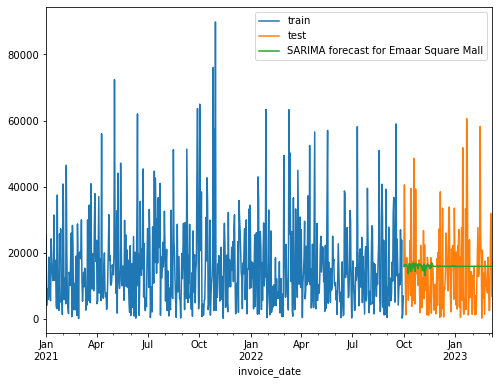

In [82]:
# Plot the dataset and forecast result
fig, ax = plt.subplots(figsize=(8, 6))

train1['sales'].plot(ax=ax, label="train")
test1['sales'].plot(ax=ax, label="test")
y_pred_seasonal_1.plot(ax=ax, label="SARIMA forecast for Emaar Square Mall")
ax.legend()

plt.show()

In [83]:
# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_1 = mean_squared_error(test1, y_pred_1) ** 0.5
sarima_error_1 = mean_squared_error(test1, y_pred_seasonal_1) ** 0.5

print('ARIMA error_1:', arima_error_1)
print('SARIMA error_1:', sarima_error_1)

ARIMA error_1: 11847.421164993566
SARIMA error_1: 11813.757920512782


####  <font style='color: green'> Forecast daily sales for other malls

* Daily sales forcast for Istinye_Park mall

In [84]:
# Convert the entire DataFrame to float
Istinye_Park=Istinye_Park.astype({'sales': float})
Kanyon=Kanyon.astype({'sales': float})
MoI=MoI.astype({'sales': float})
Metrocity=Metrocity.astype({'sales': float})
Metropol_AVM=Metropol_AVM.astype({'sales': float})
Cevahir_AVM=Cevahir_AVM.astype({'sales': float})
Viaport_Outlet=Viaport_Outlet.astype({'sales': float})
Forum_Istanbul=Forum_Istanbul.astype({'sales': float})
Zorlu_Center=Zorlu_Center.astype({'sales': float})

# Ensure that the 'invoice_date' column is a datetime index (4 other dataset need further cleaning since there are some missing days in the time series)
Istinye_Park.set_index('invoice_date', inplace=True)
Kanyon.set_index('invoice_date', inplace=True)
MoI.set_index('invoice_date', inplace=True)
Metrocity.set_index('invoice_date', inplace=True)
Metropol_AVM.set_index('invoice_date', inplace=True)

In [85]:
# Split the dataset into training and test sets
train2 =Istinye_Park["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test2 = Istinye_Park["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model2 = ARIMA(train2, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_2 = model2.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_2 = SARIMAX(train2, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_2 = seasonal_model_2.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_2 = mean_squared_error(test2, y_pred_2) ** 0.5
sarima_error_2 = mean_squared_error(test2, y_pred_seasonal_2) ** 0.5

print('ARIMA error_2:', arima_error_2)
print('SARIMA error_2:', sarima_error_2)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35866D+01    |proj g|=  4.89723D+00

At iterate    5    f=  1.14616D+01    |proj g|=  1.91122D-01

At iterate   10    f=  1.13071D+01    |proj g|=  8.37344D-02

At iterate   15    f=  1.11737D+01    |proj g|=  3.03766D-02

At iterate   20    f=  1.11423D+01    |proj g|=  1.04380D-02

At iterate   25    f=  1.11344D+01    |proj g|=  2.84419D-03

At iterate   30    f=  1.11313D+01    |proj g|=  2.13332D-03

At iterate   35    f=  1.11307D+01    |proj g|=  6.05400D-05

At iterate   40    f=  1.11306D+01    |proj g|=  2.78398D-04

At iterate   45    f=  1.11306D+01    |proj g|=  1.59138D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.11303D+01    |proj g|=  1.37868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74      2     0     0   1.379D-03   1.113D+01
  F =   11.130338332437910     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA error_2: 17093.046762976606
SARIMA error_2: 17035.361308778367


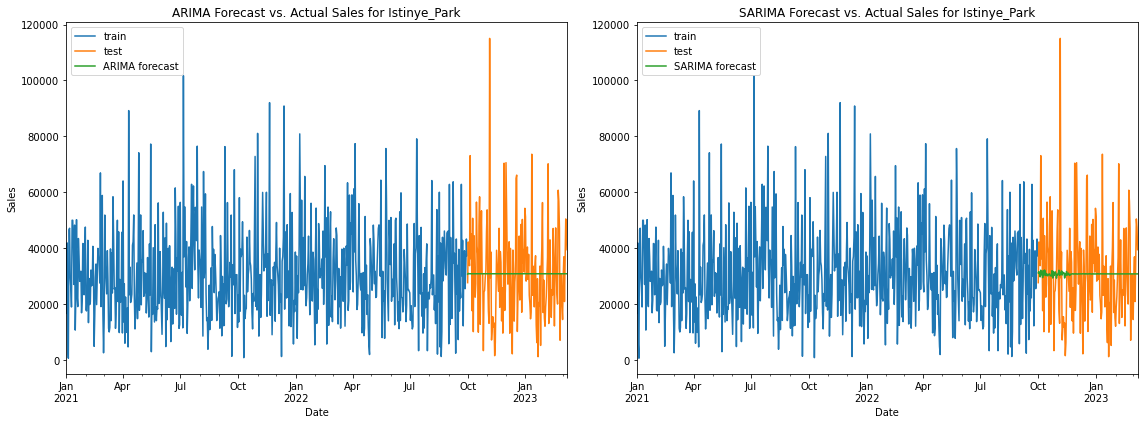

In [86]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train2['sales'].plot(ax=ax1, label="train")
test2['sales'].plot(ax=ax1, label="test")
y_pred_2.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Istinye_Park")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train2['sales'].plot(ax=ax2, label="train")
test2['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_2.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Istinye_Park")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Kanyon mall

In [87]:
# Split the dataset into training and test sets
train3 =Kanyon["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test3 = Kanyon["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model3 = ARIMA(train3, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_3 = model3.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_3 = SARIMAX(train3, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_3 = seasonal_model_3.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_3 = mean_squared_error(test3, y_pred_3) ** 0.5
sarima_error_3 = mean_squared_error(test3, y_pred_seasonal_3) ** 0.5

print('ARIMA error_3:', arima_error_3)
print('SARIMA error_3:', sarima_error_3)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19571D+01    |proj g|=  1.95090D-01

At iterate    5    f=  1.15608D+01    |proj g|=  3.13010D-03

At iterate   10    f=  1.15455D+01    |proj g|=  5.11472D-03

At iterate   15    f=  1.15384D+01    |proj g|=  8.83294D-03

At iterate   20    f=  1.15350D+01    |proj g|=  1.77167D-03

At iterate   25    f=  1.15338D+01    |proj g|=  2.55715D-04

At iterate   30    f=  1.15336D+01    |proj g|=  3.62173D-04

At iterate   35    f=  1.15335D+01    |proj g|=  9.13588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA error_3: 26178.780886810022
SARIMA error_3: 26231.69334385534


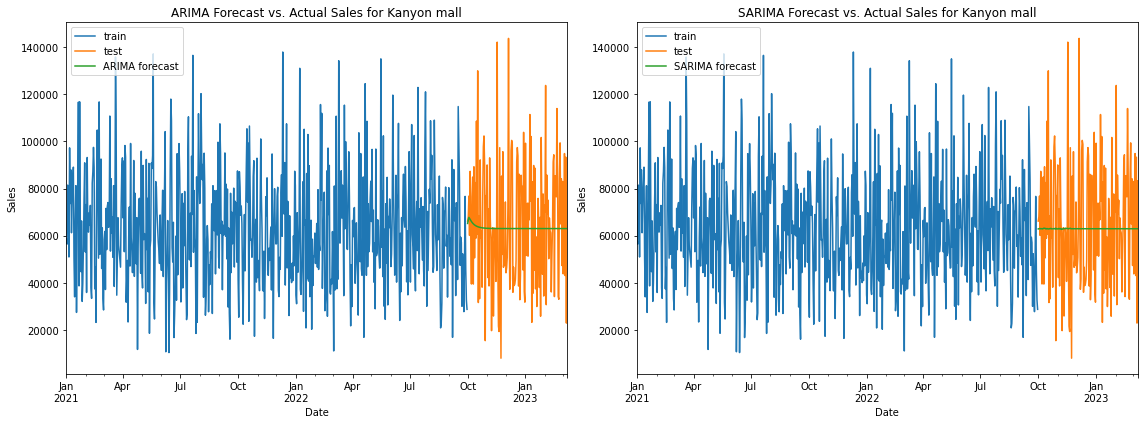

In [88]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train3['sales'].plot(ax=ax1, label="train")
test3['sales'].plot(ax=ax1, label="test")
y_pred_3.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Kanyon mall")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train3['sales'].plot(ax=ax2, label="train")
test3['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_3.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Kanyon mall")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Mall of Istanbul

In [89]:
# Split the dataset into training and test sets
train4 =MoI["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test4 = MoI["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model4 = ARIMA(train4, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_4 = model4.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_4 = SARIMAX(train4, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_4 = seasonal_model_4.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_4 = mean_squared_error(test4, y_pred_4) ** 0.5
sarima_error_4 = mean_squared_error(test4, y_pred_seasonal_4) ** 0.5

print('ARIMA error_4:', arima_error_4)
print('SARIMA error_4:', sarima_error_4)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19674D+01    |proj g|=  2.08204D-01

At iterate    5    f=  1.15980D+01    |proj g|=  2.52426D-02

At iterate   10    f=  1.15956D+01    |proj g|=  3.01534D-02

At iterate   15    f=  1.15777D+01    |proj g|=  1.13150D-02

At iterate   20    f=  1.15743D+01    |proj g|=  2.34926D-03

At iterate   25    f=  1.15710D+01    |proj g|=  5.22404D-03

At iterate   30    f=  1.15701D+01    |proj g|=  2.07279D-03

At iterate   35    f=  1.15700D+01    |proj g|=  6.47502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

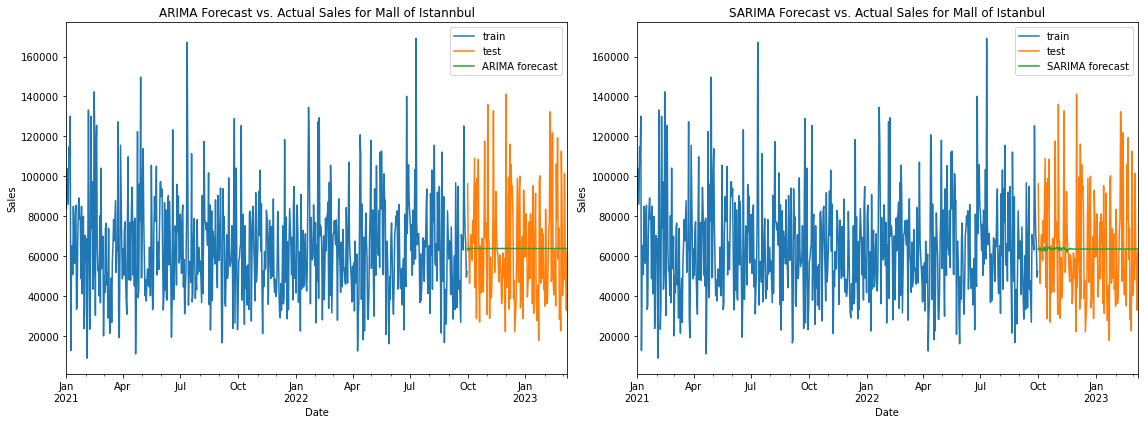

In [90]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train4['sales'].plot(ax=ax1, label="train")
test4['sales'].plot(ax=ax1, label="test")
y_pred_4.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Mall of Istannbul")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train4['sales'].plot(ax=ax2, label="train")
test4['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_4.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Mall of Istanbul")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

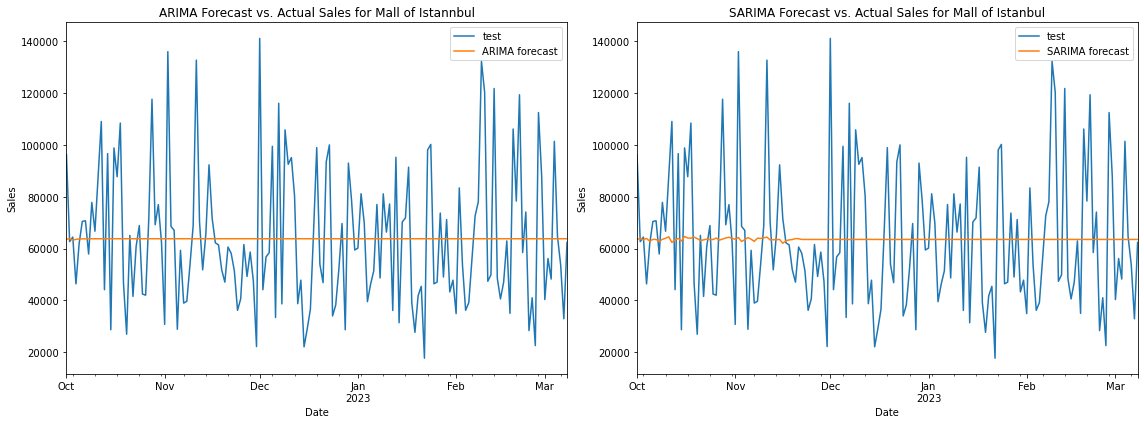

In [91]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
test4['sales'].plot(ax=ax1, label="test")
y_pred_4.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Mall of Istannbul")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
test4['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_4.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Mall of Istanbul")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Metrocity mall

In [92]:
# Split the dataset into training and test sets
train5 =Metrocity["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test5 = Metrocity["2022-10-01":"2023-03-08"]  # From September to December 2022 (3 months)

# Fit data into ARIMA model

model5 = ARIMA(train5, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_5 = model5.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_5 = SARIMAX(train5, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_5 = seasonal_model_5.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_5 = mean_squared_error(test5, y_pred_5) ** 0.5
sarima_error_5 = mean_squared_error(test5, y_pred_seasonal_5) ** 0.5

print('ARIMA error_5:', arima_error_5)
print('SARIMA error_5:', sarima_error_5)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16993D+01    |proj g|=  1.20440D-01

At iterate    5    f=  1.13685D+01    |proj g|=  2.78941D-03

At iterate   10    f=  1.13684D+01    |proj g|=  7.97099D-03

At iterate   15    f=  1.13649D+01    |proj g|=  4.24641D-02

At iterate   20    f=  1.13598D+01    |proj g|=  5.47260D-03

At iterate   25    f=  1.13589D+01    |proj g|=  1.57673D-03

At iterate   30    f=  1.13588D+01    |proj g|=  5.20391D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

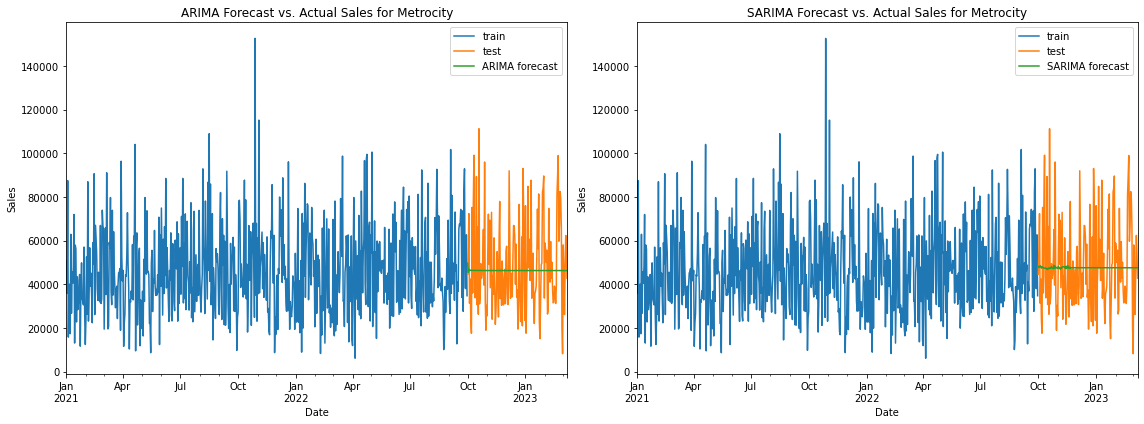

In [93]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train5['sales'].plot(ax=ax1, label="train")
test5['sales'].plot(ax=ax1, label="test")
y_pred_5.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Metrocity")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train5['sales'].plot(ax=ax2, label="train")
test5['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_5.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Metrocity")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Metropol_AVM mall

In [94]:
# Split the dataset into training and test sets
train6 =Metropol_AVM["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test6 = Metropol_AVM["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model6 = ARIMA(train4, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_6 = model6.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_6 = SARIMAX(train4, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_6 = seasonal_model_6.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_6 = mean_squared_error(test6, y_pred_6) ** 0.5
sarima_error_6 = mean_squared_error(test6, y_pred_seasonal_6) ** 0.5

print('ARIMA error_6:', arima_error_6)
print('SARIMA error_6:', sarima_error_6)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19674D+01    |proj g|=  2.08204D-01

At iterate    5    f=  1.15980D+01    |proj g|=  2.52426D-02

At iterate   10    f=  1.15956D+01    |proj g|=  3.01534D-02

At iterate   15    f=  1.15777D+01    |proj g|=  1.13150D-02

At iterate   20    f=  1.15743D+01    |proj g|=  2.34926D-03

At iterate   25    f=  1.15710D+01    |proj g|=  5.22404D-03

At iterate   30    f=  1.15701D+01    |proj g|=  2.07279D-03

At iterate   35    f=  1.15700D+01    |proj g|=  6.47502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

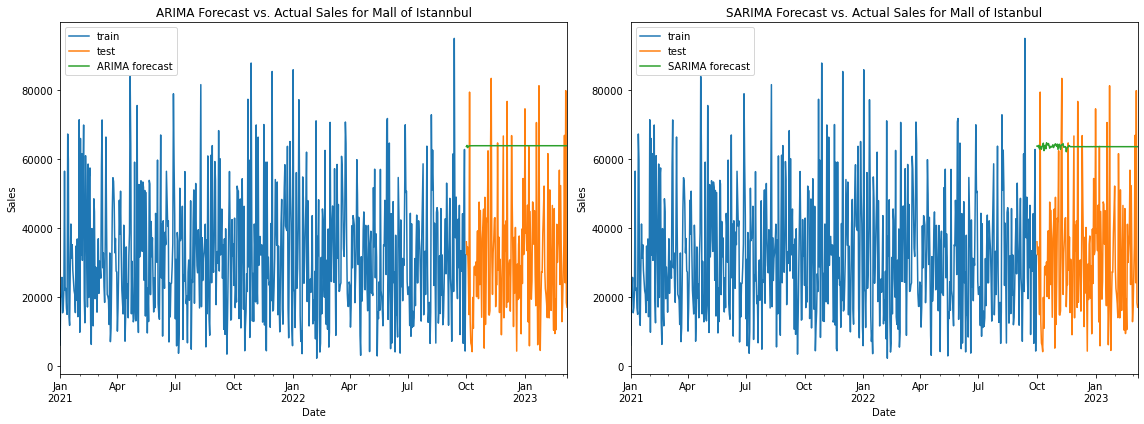

In [95]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train6['sales'].plot(ax=ax1, label="train")
test6['sales'].plot(ax=ax1, label="test")
y_pred_6.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Mall of Istannbul")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train6['sales'].plot(ax=ax2, label="train")
test6['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_6.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Mall of Istanbul")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

For Cevahir AVM, Viaport Outlet, Forum Istanbul and Zorlu Center, there are some missing days in the dataset. In order to run time series model, we will identify the missing date in the dataset and replace sales of this day with average sale.

* Daily sales forcast for Cevahir_AVM mall

In [96]:
# Create the expected date range
start_date = '2021-01-01'
end_date = '2023-03-08'
expected_date_range = pd.date_range(start=start_date, end=end_date)

# Find the missing date(s)
missing_dates_1 = [date for date in expected_date_range if date not in Cevahir_AVM['invoice_date'].dt.date.unique()]
missing_dates_2 = [date for date in expected_date_range if date not in Viaport_Outlet['invoice_date'].dt.date.unique()]
missing_dates_3 = [date for date in expected_date_range if date not in Forum_Istanbul['invoice_date'].dt.date.unique()]
missing_dates_4 = [date for date in expected_date_range if date not in Zorlu_Center['invoice_date'].dt.date.unique()]

# Display the missing date(s)
print("Missing Date(s) in Cevahir_AVM:", missing_dates_1)
print("Missing Date(s) in Viaport_Outlet:", missing_dates_2)
print("Missing Date(s) in Forum_Istanbul:", missing_dates_3)
print("Missing Date(s) in Zorlu_Center:", missing_dates_4)


/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/141425651.py:7: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/141425651.py:8: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/141425651.py:9: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

/var/folders/l1/pw4

Missing Date(s) in Cevahir_AVM: [Timestamp('2021-10-24 00:00:00', freq='D')]
Missing Date(s) in Viaport_Outlet: [Timestamp('2022-11-07 00:00:00', freq='D')]
Missing Date(s) in Forum_Istanbul: [Timestamp('2022-01-18 00:00:00', freq='D'), Timestamp('2022-06-22 00:00:00', freq='D')]
Missing Date(s) in Zorlu_Center: [Timestamp('2021-09-26 00:00:00', freq='D'), Timestamp('2021-12-12 00:00:00', freq='D'), Timestamp('2022-05-25 00:00:00', freq='D')]


In [97]:
# Set the missing date
missing_date = pd.to_datetime('2021-10-24')

# Calculate the average of sales
average_sales = Cevahir_AVM['sales'].mean()

# Create a new row with the missing date and average sales
missing_row = pd.DataFrame({'invoice_date': [missing_date], 'sales': [average_sales]})

# Concatenate the missing row with the original DataFrame
Cevahir_AVM = pd.concat([Cevahir_AVM, missing_row], ignore_index=True)

# Sort the DataFrame by 'invoice_date'
Cevahir_AVM = Cevahir_AVM.sort_values(by='invoice_date')
Cevahir_AVM.shape

(797, 2)

In [98]:
# Set the missing date
missing_date_2 = pd.to_datetime('2022-11-07')

# Calculate the average of sales
average_sales = Viaport_Outlet['sales'].mean()

# Create a new row with the missing date and average sales
missing_row_2 = pd.DataFrame({'invoice_date': [missing_date_2], 'sales': [average_sales]})

# Concatenate the missing row with the original DataFrame
Viaport_Outlet = pd.concat([Viaport_Outlet, missing_row_2], ignore_index=True)

# Sort the DataFrame by 'invoice_date'
Viaport_Outlet = Cevahir_AVM.sort_values(by='invoice_date')
Viaport_Outlet.shape

(797, 2)

In [99]:
# Set the missing dates
missing_dates = pd.to_datetime(['2022-01-18', '2022-06-22'])

# Calculate the average sales for each missing date and add a row for each
for missing_date in missing_dates:
    average_sales = Forum_Istanbul['sales'].mean()
    missing_row = pd.DataFrame({'invoice_date': [missing_date], 'sales': [average_sales]})
    Forum_Istanbul = pd.concat([Forum_Istanbul, missing_row], ignore_index=True)
Forum_Istanbul.shape

(797, 2)

In [100]:
# Sort the DataFrame by 'invoice_date'
Forum_Istanbul = Forum_Istanbul.sort_values(by='invoice_date')

In [101]:
# Set the missing dates
missing_dates_2 = pd.to_datetime(['2021-09-26', '2021-12-12', '2022-05-25'])

# Create an empty DataFrame to store the missing rows
missing_rows_2 = pd.DataFrame(columns=['invoice_date', 'sales'])

# Calculate the average sales for each missing date and add a row for each
for missing_date in missing_dates_2:
    average_sales = Zorlu_Center['sales'].mean()
    missing_row = pd.DataFrame({'invoice_date': [missing_date], 'sales': [average_sales]})
    missing_rows_2 = pd.concat([missing_rows_2, missing_row], ignore_index=True)

# Concatenate the missing rows with the original DataFrame
Zorlu_Center = pd.concat([Zorlu_Center, missing_rows_2], ignore_index=True)
Zorlu_Center.shape

(797, 2)

In [102]:
# Sort the DataFrame by 'invoice_date'
Zorlu_Center = Zorlu_Center.sort_values(by='invoice_date')

Save to .csv for further analysis

In [103]:
file_names = {
    'Zorlu_Center': Zorlu_Center,
    'Forum_Istanbul': Forum_Istanbul,
    'Viaport_Outlet': Viaport_Outlet,
    'Cevahir_AVM': Cevahir_AVM
}

# Loop through the DataFrames and save them as CSV files
for mall_name, df in file_names.items():
    df.to_csv(f"{mall_name}.csv", index=False)

In [104]:
Cevahir_AVM.set_index('invoice_date', inplace=True)
Viaport_Outlet.set_index('invoice_date', inplace=True)
Forum_Istanbul.set_index('invoice_date', inplace=True)
Zorlu_Center.set_index('invoice_date', inplace=True)

* Daily sales forcast for Cevahir_AVM mall

In [105]:
# Split the dataset into training and test sets
train7 = Cevahir_AVM["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test7 = Cevahir_AVM["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model7 = ARIMA(train7, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_7 = model7.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_7 = SARIMAX(train7, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_7 = seasonal_model_7.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_7 = mean_squared_error(test7, y_pred_7) ** 0.5
sarima_error_7 = mean_squared_error(test7, y_pred_seasonal_7) ** 0.5

print('ARIMA error_7:', arima_error_7)
print('SARIMA error_7:', sarima_error_7)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35470D+01    |proj g|=  5.49778D+00

At iterate    5    f=  1.10431D+01    |proj g|=  1.09536D-01

At iterate   10    f=  1.09227D+01    |proj g|=  2.87198D-02

At iterate   15    f=  1.08866D+01    |proj g|=  5.13791D-03

At iterate   20    f=  1.08768D+01    |proj g|=  3.96364D-03

At iterate   25    f=  1.08746D+01    |proj g|=  7.76785D-04

At iterate   30    f=  1.08738D+01    |proj g|=  1.36346D-03

At iterate   35    f=  1.08737D+01    |proj g|=  2.25803D-05

At iterate   40    f=  1.08737D+01    |proj g|=  7.58504D-04

At iterate   45    f=  1.08726D+01    |proj g|=  1.35081D-02
  ys=-1.925E-02  -gs= 1.571E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.08724D+01    |proj g|=  3.88397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     89      2     1     0   3.884D-03   1.087D+01
  F =   10.872436827119468     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA error_7: 12384.162117703954
SARIMA error_7: 12372.574016701756


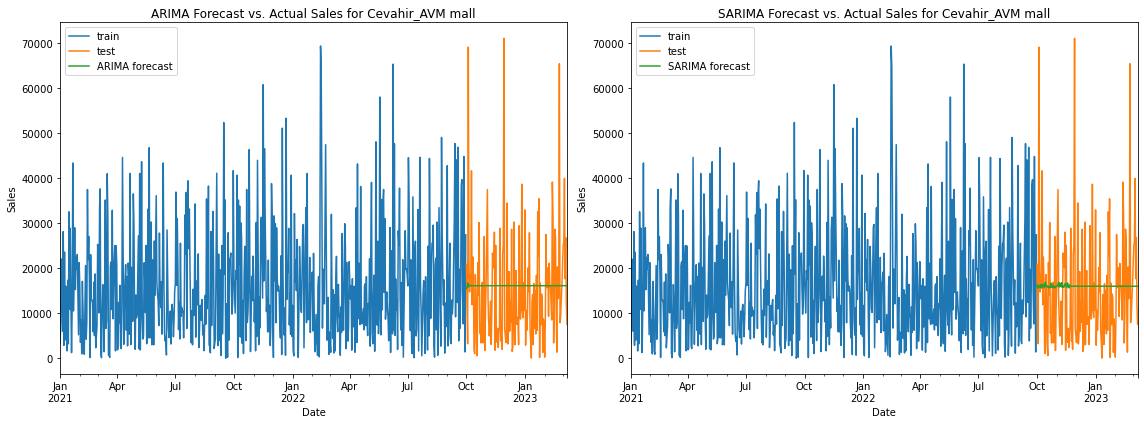

In [106]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train7['sales'].plot(ax=ax1, label="train")
test7['sales'].plot(ax=ax1, label="test")
y_pred_7.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Cevahir_AVM mall")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train7['sales'].plot(ax=ax2, label="train")
test7['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_7.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Cevahir_AVM mall")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Viaport_Outlet mall

In [107]:
# Split the dataset into training and test sets
train8 = Viaport_Outlet ["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test8 = Viaport_Outlet ["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model8 = ARIMA(train8, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_8 = model8.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_8 = SARIMAX(train8, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_8 = seasonal_model_8.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_8 = mean_squared_error(test8, y_pred_8) ** 0.5
sarima_error_8 = mean_squared_error(test8, y_pred_seasonal_8) ** 0.5

print('ARIMA error_8:', arima_error_8)
print('SARIMA error_8:', sarima_error_8)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35470D+01    |proj g|=  5.49778D+00

At iterate    5    f=  1.10431D+01    |proj g|=  1.09536D-01

At iterate   10    f=  1.09227D+01    |proj g|=  2.87198D-02

At iterate   15    f=  1.08866D+01    |proj g|=  5.13791D-03

At iterate   20    f=  1.08768D+01    |proj g|=  3.96364D-03

At iterate   25    f=  1.08746D+01    |proj g|=  7.76785D-04

At iterate   30    f=  1.08738D+01    |proj g|=  1.36346D-03

At iterate   35    f=  1.08737D+01    |proj g|=  2.25803D-05

At iterate   40    f=  1.08737D+01    |proj g|=  7.58504D-04

At iterate   45    f=  1.08726D+01    |proj g|=  1.35081D-02
  ys=-1.925E-02  -gs= 1.571E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.08724D+01    |proj g|=  3.88397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     89      2     1     0   3.884D-03   1.087D+01
  F =   10.872436827119468     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA error_8: 12384.162117703954
SARIMA error_8: 12372.574016701756


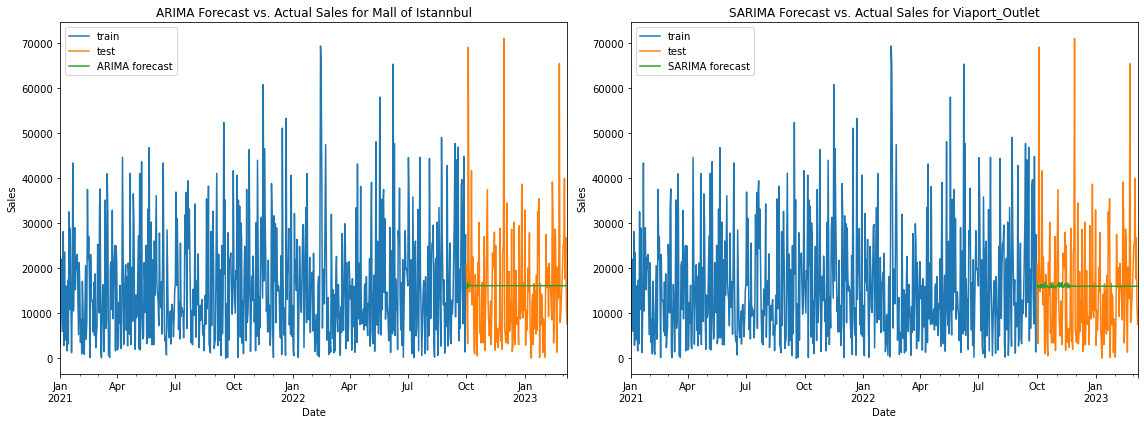

In [108]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train8['sales'].plot(ax=ax1, label="train")
test8['sales'].plot(ax=ax1, label="test")
y_pred_8.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Mall of Istannbul")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train8['sales'].plot(ax=ax2, label="train")
test8['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_8.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Viaport_Outlet")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Forum_Istanbul mall

In [109]:
# Split the dataset into training and test sets
train9 = Forum_Istanbul["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test9 = Forum_Istanbul["2022-10-01":"2023-03-08"]  # From September to December 2022 (6 months)

# Fit data into ARIMA model

model9 = ARIMA(train9, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_9 = model9.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model

seasonal_model_9 = SARIMAX(train9, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_9 = seasonal_model_9.predict(start="2022-10-01", end="2023-03-08")

# Compare ARIMA and SARIMAX model
from sklearn.metrics import mean_squared_error

arima_error_9 = mean_squared_error(test9, y_pred_9) ** 0.5
sarima_error_9 = mean_squared_error(test9, y_pred_seasonal_9) ** 0.5

print('ARIMA error_9:', arima_error_9)
print('SARIMA error_9:', sarima_error_9)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10213D+01    |proj g|=  2.46119D-01

At iterate    5    f=  1.08219D+01    |proj g|=  2.98626D-02

At iterate   10    f=  1.08184D+01    |proj g|=  7.36622D-03

At iterate   15    f=  1.08116D+01    |proj g|=  1.67087D-02

At iterate   20    f=  1.08060D+01    |proj g|=  1.03859D-03

At iterate   25    f=  1.08045D+01    |proj g|=  5.78032D-03

At iterate   30    f=  1.08040D+01    |proj g|=  6.63195D-04

At iterate   35    f=  1.08038D+01    |proj g|=  8.57658D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  1.08035D+01    |proj g|=  5.08491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     71      2     0     0   5.085D-05   1.080D+01
  F =   10.803542862473250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA error_9: 12249.34659299809
SARIMA error_9: 12249.949279241211


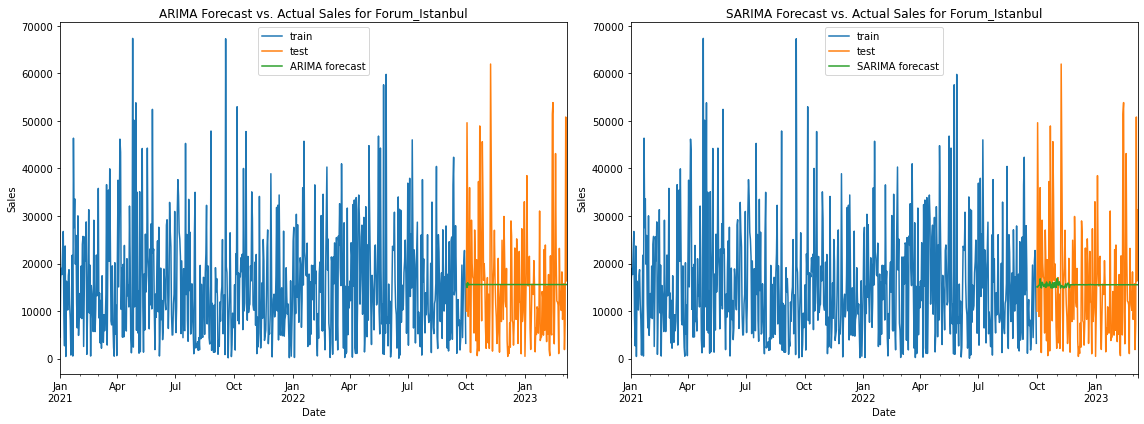

In [110]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train9['sales'].plot(ax=ax1, label="train")
test9['sales'].plot(ax=ax1, label="test")
y_pred_9.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Forum_Istanbul")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train9['sales'].plot(ax=ax2, label="train")
test9['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_9.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Forum_Istanbul")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

* Daily sales forcast for Zorlu_Center mall

In [111]:
Zorlu_Center = Zorlu_Center.astype({'sales': float})

In [112]:
# Split the dataset into training and test sets
train_10 = Zorlu_Center["2021-01-01":"2022-09-30"]  # From January 2021 to September 2022 (21 months)
test_10 = Zorlu_Center["2022-10-01":"2023-03-08"]  # From October 2022 to March 2023 (6 months)

# Fit data into ARIMA model
model_10 = ARIMA(train_10, order=(3, 0, 1)).fit()

# Forecast sales for the testing period
y_pred_10 = model_10.predict(start="2022-10-01", end="2023-03-08", dynamic=True)

# Fit data into SARIMAX model
seasonal_model_10 = SARIMAX(train_10, order=(1, 0, 1), seasonal_order=(1, 0, 0, 52), freq="D").fit()
y_pred_seasonal_10 = seasonal_model_10.predict(start="2022-10-01", end="2023-03-08")

# Calculate RMSE for ARIMA and SARIMAX
arima_error_10 = mean_squared_error(test_10, y_pred_10, squared=False)
sarima_error_10 = mean_squared_error(test_10, y_pred_seasonal_10, squared=False)

print('ARIMA RMSE:', arima_error_10)
print('SARIMA RMSE:', sarima_error_10)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11185D+01    |proj g|=  2.64983D-01

At iterate    5    f=  1.09109D+01    |proj g|=  1.25023D-02

At iterate   10    f=  1.08846D+01    |proj g|=  8.54566D-03

At iterate   15    f=  1.08753D+01    |proj g|=  5.07263D-03

At iterate   20    f=  1.08691D+01    |proj g|=  3.74080D-03

At iterate   25    f=  1.08669D+01    |proj g|=  1.19433D-03

At iterate   30    f=  1.08668D+01    |proj g|=  1.62048D-04

At iterate   35    f=  1.08668D+01    |proj g|=  8.12319D-05

At iterate   40    f=  1.08666D+01    |proj g|=  2.90250D-03

At iterate   45    f=  1.08519D+01    |proj g|=  2.96077D-02


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.08501D+01    |proj g|=  3.21208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   3.212D-03   1.085D+01
  F =   10.850100851551018     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA RMSE: 12236.69208329802
SARIMA RMSE: 12268.37374868865


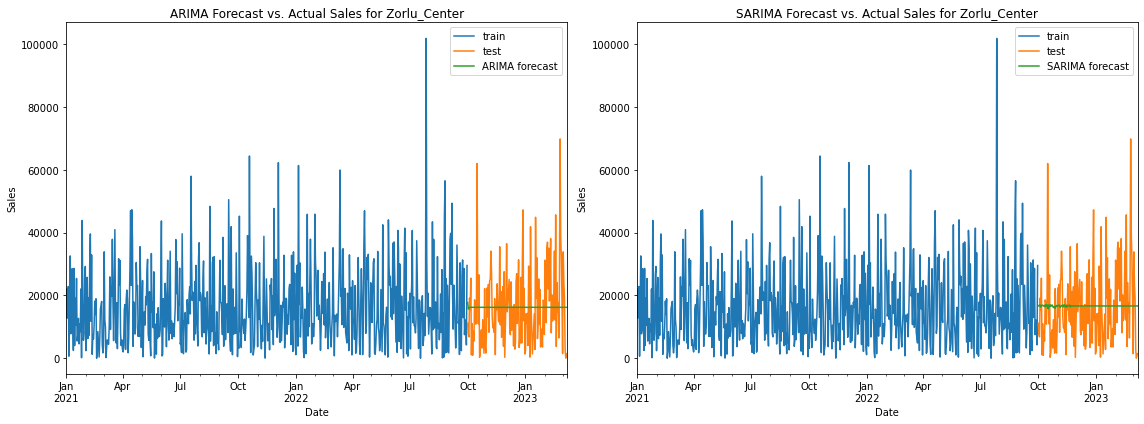

In [113]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# Plot the first graph (ARIMA forecast) on the left subplot (ax1)
train_10['sales'].plot(ax=ax1, label="train")
test_10['sales'].plot(ax=ax1, label="test")
y_pred_10.plot(ax=ax1, label="ARIMA forecast")
ax1.set_xlabel("Date")
ax1.set_ylabel("Sales")
ax1.set_title("ARIMA Forecast vs. Actual Sales for Zorlu_Center")
ax1.legend()

# Plot the second graph (SARIMA forecast) on the right subplot (ax2)
train_10['sales'].plot(ax=ax2, label="train")
test_10['sales'].plot(ax=ax2, label="test")
y_pred_seasonal_10.plot(ax=ax2, label="SARIMA forecast")
ax2.set_xlabel("Date")
ax2.set_ylabel("Sales")
ax2.set_title("SARIMA Forecast vs. Actual Sales for Zorlu_Center")
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

#### [Home](#home)
<a id="XGboost_model"></a>
###  <font style='color: green'> XGboost model <font>

<a id="Forecast_the_whole_dateset_daily_sales"></a>
#### <font style='color: green'> Forecast the whole dateset daily sales

In [114]:
conda install -c anaconda py-xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [115]:
import xgboost as xgb

/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



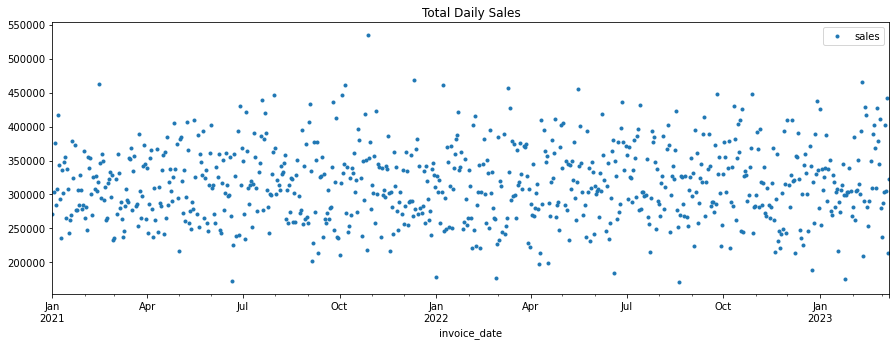

In [116]:
# Create a scatter plot
total_daily_sales.plot(style='.', figsize=(15, 5), title='Total Daily Sales')

# Show the plot
plt.show()

<font style='color: green'> Train/Test split

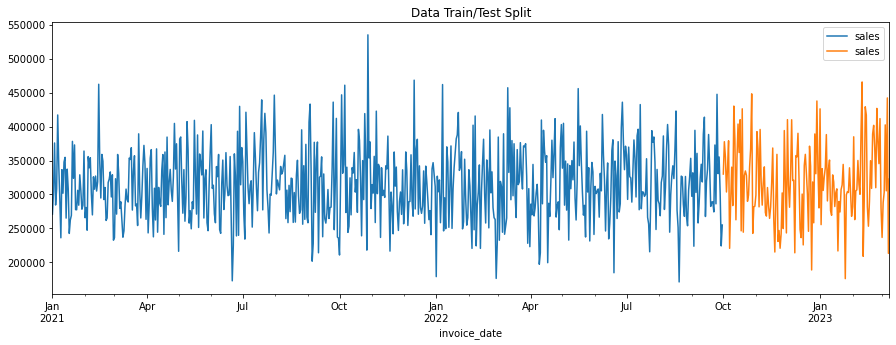

In [117]:
# Train/Test split
train=total_daily_sales.loc[total_daily_sales.index<'2022-10-01']
test=total_daily_sales.loc[total_daily_sales.index>='2022-10-01']

fig, ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test set')
plt.show()

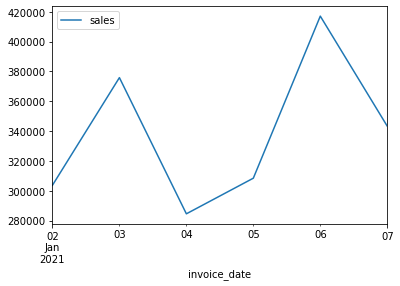

In [118]:
total_daily_sales.loc[(total_daily_sales.index >= '2021-01-02') & (total_daily_sales.index <= '2021-01-07')].plot();

<font style='color: green'> Feature Creation

In [119]:
def create_feature(df):
    df['dayofweek']=df.index.day_of_week
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df

total_daily_sales=create_feature(total_daily_sales)
total_daily_sales.head()

sales  dayofweek  quarter  month  year  dayofyear
invoice_date                                                       
2021-01-01    271192.66          4        1      1  2021          1
2021-01-02    303659.14          5        1      1  2021          2
2021-01-03    375794.99          6        1      1  2021          3
2021-01-04    284512.26          0        1      1  2021          4
2021-01-05    308395.08          1        1      1  2021          5

<font style='color: green'> Visualize Feature/Target relationship

<AxesSubplot:xlabel='dayofweek', ylabel='sales'>

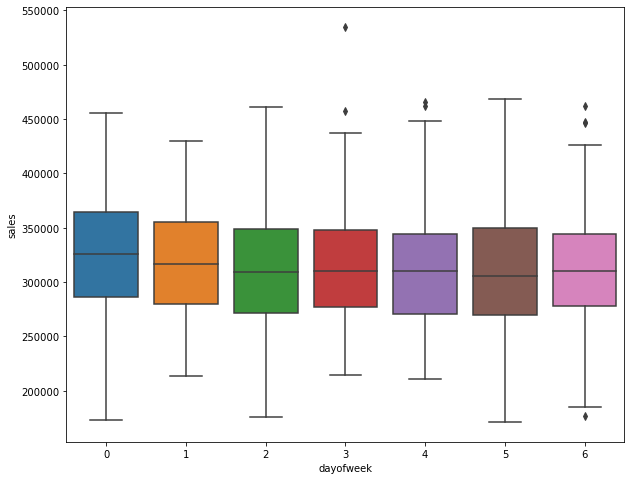

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=total_daily_sales, x='dayofweek', y='sales')

<AxesSubplot:xlabel='quarter', ylabel='sales'>

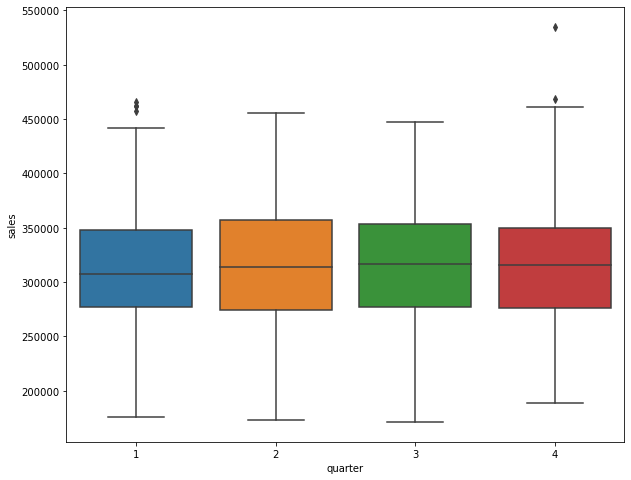

In [121]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=total_daily_sales, x='quarter', y='sales')

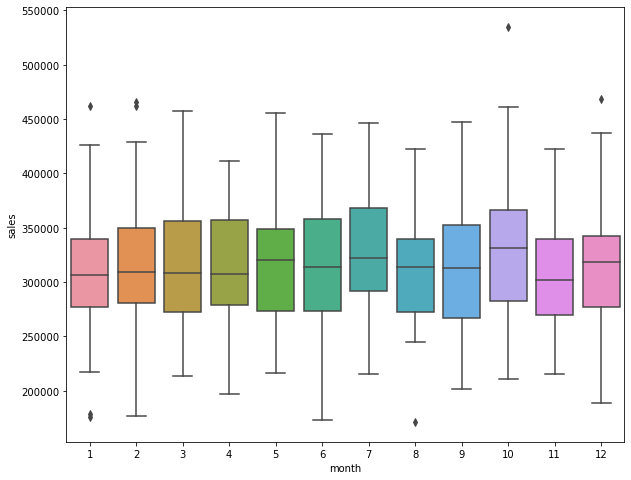

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=total_daily_sales, x='month', y='sales');

<font style='color: green'> Create our model

In [123]:
train = create_feature(train)
test = create_feature(test)

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/2279663478.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/2279663478.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/2279663478.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [124]:
features=['dayofweek','quarter','month','year','dayofyear']
target=['sales']
X_train=train[features]
y_train=train[target]

X_test=test[features]
y_test=test[target]

In [125]:
reg=xgb.XGBRegressor(n_estimator=100, early_stopping_rounds=50,
                    learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[23:14:45] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:316402.21875	validation_1-rmse:320473.18750
[99]	validation_0-rmse:127425.90625	validation_1-rmse:132860.28125


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimator=100, n_estimators=100,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<font style='color: green'> Feature Importance

In [126]:
fi = pd.DataFrame(data=reg.feature_importances_, 
                  index=features,
                  columns=['importance'])

<Figure size 1728x1152 with 0 Axes>

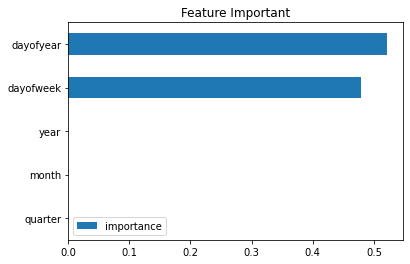

In [127]:
plt.figure(figsize=(24, 16))
fi.sort_values('importance').plot(kind='barh', title='Feature Important')
plt.show();

<font style='color: green'> Forecast on the test set

In [128]:
test['prediction'] = reg.predict(X_test)
total_daily_sales = total_daily_sales.merge(test[['prediction']], how='left', left_index=True, right_index=True)

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/3919772499.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [129]:
total_daily_sales.head()

sales  dayofweek  quarter  month  year  dayofyear  \
invoice_date                                                          
2021-01-01    271192.66          4        1      1  2021          1   
2021-01-02    303659.14          5        1      1  2021          2   
2021-01-03    375794.99          6        1      1  2021          3   
2021-01-04    284512.26          0        1      1  2021          4   
2021-01-05    308395.08          1        1      1  2021          5   

              prediction  
invoice_date              
2021-01-01           NaN  
2021-01-02           NaN  
2021-01-03           NaN  
2021-01-04           NaN  
2021-01-05           NaN

Text(0.5, 1.0, 'Raw data and prediction of basic XGBoost model')

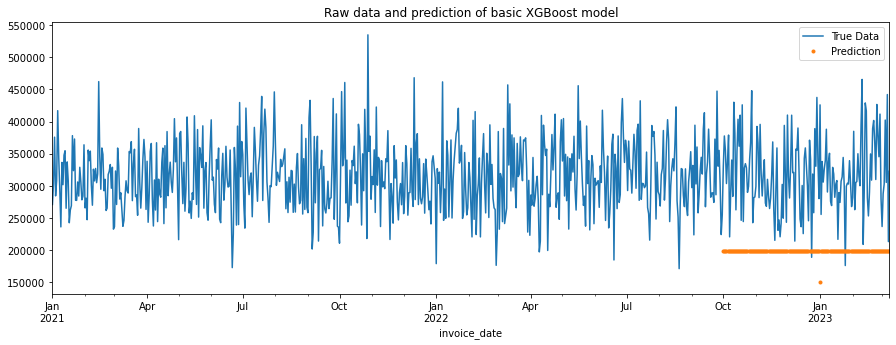

In [130]:
ax = total_daily_sales['sales'].plot(figsize=(15,5))
total_daily_sales['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Prediction'])
ax.set_title('Raw data and prediction of basic XGBoost model')

In [131]:
np.sqrt(mean_squared_error(test['sales'], test['prediction']))

132860.2849070801

In [132]:
features_2=['dayofweek','dayofyear']
target=['sales']
X_train_2=train[features_2]
y_train_2=train[target]

X_test_2=test[features_2]
y_test_2=test[target]

In [133]:
reg=xgb.XGBRegressor(n_estimator=100, early_stopping_rounds=50,
                    learning_rate=0.01)
reg.fit(X_train_2, y_train_2,
        eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)],
        verbose=100)

[23:14:45] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:316402.21875	validation_1-rmse:320473.18750
[99]	validation_0-rmse:127425.90625	validation_1-rmse:132860.29688


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimator=100, n_estimators=100,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [134]:
test['prediction2'] = reg.predict(X_test_2)
total_daily_sales = total_daily_sales.merge(test[['prediction2']], how='left', left_index=True, right_index=True)

/var/folders/l1/pw48dc_x0vx9y483d59sr_jr0000gn/T/ipykernel_6891/1736701691.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Raw data and prediction')

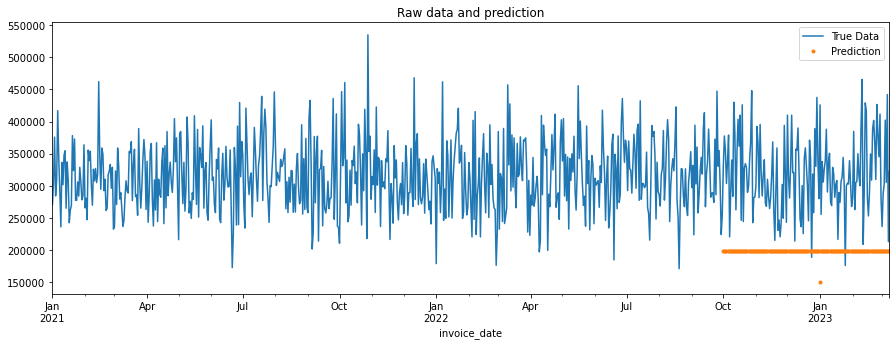

In [135]:
ax = total_daily_sales['sales'].plot(figsize=(15,5))
total_daily_sales['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Prediction'])
ax.set_title('Raw data and prediction')

In [136]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],     # Learning rate
    'max_depth': [3, 4, 5],                # Maximum depth of trees
    'min_child_weight': [1, 2, 3]          # Minimum sum of instance weight (hessian) needed in a child
}

# Create the XGBoost regressor
reg = xgb.XGBRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=2)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_reg = xgb.XGBRegressor(**best_params)
best_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100, early_stopping_rounds=50)

# Evaluate the model
y_pred = best_reg.predict(X_test)

# You can calculate metrics like RMSE to evaluate the model's performance
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.4s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.5s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.1s

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.




[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=200; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=200; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.3s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=100; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300; total time=   0.2s


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
[0]	validation_0-rmse:288562.34375	validation_1-rmse:292696.15625
[99]	validation_0-rmse:47554.31641	validation_1-rmse:61007.24609
Root Mean Squared Error (RMSE): 59913.34732829033


_Note: Best RMSE of XGBoost model is 59913.34732829033, higher then the ARIMA ans SARIMA model (58446 and 58473). But the graph show that XGBoost model prediction actually fit the test set more than ARIMA and SARIMA model._

In [137]:
test['best_prediction'] = best_reg.predict(X_test)
total_daily_sales = total_daily_sales.merge(test[['best_prediction']], how='left', left_index=True, right_index=True)

In [138]:
total_daily_sales.head()

sales  dayofweek  quarter  month  year  dayofyear  \
invoice_date                                                          
2021-01-01    271192.66          4        1      1  2021          1   
2021-01-02    303659.14          5        1      1  2021          2   
2021-01-03    375794.99          6        1      1  2021          3   
2021-01-04    284512.26          0        1      1  2021          4   
2021-01-05    308395.08          1        1      1  2021          5   

              prediction  prediction2  best_prediction  
invoice_date                                            
2021-01-01           NaN          NaN              NaN  
2021-01-02           NaN          NaN              NaN  
2021-01-03           NaN          NaN              NaN  
2021-01-04           NaN          NaN              NaN  
2021-01-05           NaN          NaN              NaN

Text(0.5, 1.0, 'Raw data and Best XGBoost prediction')

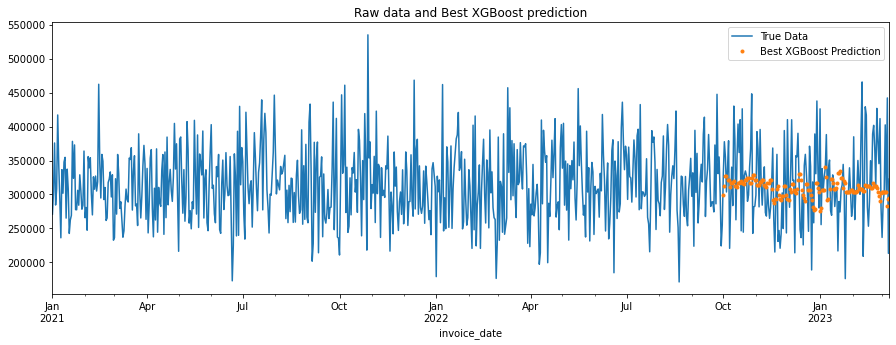

In [139]:
ax = total_daily_sales['sales'].plot(figsize=(15,5))
total_daily_sales['best_prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Best XGBoost Prediction'])
ax.set_title('Raw data and Best XGBoost prediction')

In [140]:
# Get the model's parameters
params = best_reg.get_params()

# Print the model's parameters
print("XGBoost Model Parameters:")
for param_name, param_value in params.items():
    print(f"{param_name}: {param_value}")

XGBoost Model Parameters:
objective: reg:squarederror
base_score: 0.5
booster: gbtree
colsample_bylevel: 1
colsample_bynode: 1
colsample_bytree: 1
enable_categorical: False
gamma: 0
gpu_id: -1
importance_type: None
interaction_constraints: 
learning_rate: 0.1
max_delta_step: 0
max_depth: 3
min_child_weight: 3
missing: nan
monotone_constraints: ()
n_estimators: 100
n_jobs: 4
num_parallel_tree: 1
predictor: auto
random_state: 0
reg_alpha: 0
reg_lambda: 1
scale_pos_weight: 1
subsample: 1
tree_method: exact
validate_parameters: 1
verbosity: None


#### [Home](#home)
<a id="XGboost_Forecast_for_each_shopping_mall"></a>
#### <font style='color: green'> Forecast_for_each_shopping_mall

In [141]:
Istinye_Park = pd.read_csv('Istinye_Park.csv')
Kanyon = pd.read_csv('Kanyon.csv')
MoI = pd.read_csv('MoI.csv')
Metrocity = pd.read_csv('Metrocity.csv')
Metropol_AVM = pd.read_csv('Metropol_AVM.csv')
Cevahir_AVM = pd.read_csv('Cevahir_AVM.csv')
Viaport_Outlet = pd.read_csv('Viaport_Outlet.csv')
Forum_Istanbul = pd.read_csv('Forum_Istanbul.csv')
Zorlu_Center = pd.read_csv('Zorlu_Center.csv')
Emaar_Square_Mall = pd.read_csv('Emaar_Square_Mall.csv')

In [142]:
from math import sqrt

# List of dataset names
malls = ["Istinye_Park", "Kanyon", "MoI", "Metrocity", "Metropol_AVM", 
         "Cevahir_AVM", "Viaport_Outlet", "Forum_Istanbul", "Zorlu_Center", "Emaar_Square_Mall"]

# Function to create features (replace this with your actual feature creation function)
def create_feature(df):
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])  # Convert the invoice_date column to datetime
    df['dayofweek'] = df['invoice_date'].dt.dayofweek
    df['quarter'] = df['invoice_date'].dt.quarter
    df['month'] = df['invoice_date'].dt.month
    df['year'] = df['invoice_date'].dt.year
    df['dayofyear'] = df['invoice_date'].dt.dayofyear
    return df

In [143]:
# Create empty lists to store RMSE values and predictions
rmse_values = []
all_predictions = []

# Loop through each mall dataset
for mall_name in malls:
    # Load the dataset (replace 'mall_data.csv' with the actual dataset file name)
    mall_data = pd.read_csv(f"{mall_name}.csv")  # Assuming data is in CSV format
    
    # Create features (replace with your feature creation function)
    mall_data = create_feature(mall_data)
    
    # Train/Test split
    train = mall_data[mall_data['invoice_date'] < '2022-10-01']
    test = mall_data[mall_data['invoice_date'] >= '2022-10-01']
    
    # Define features and target
    features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
    target = ['sales']
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Initialize and train the XGBoost model
    reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, early_stopping_rounds=50)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    # Make predictions
    y_pred = reg.predict(X_test)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    
    # Store predictions for plotting
    all_predictions.append((y_test, y_pred, mall_name))

[23:15:33] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:34493.51172	validation_1-rmse:35399.26172


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[99]	validation_0-rmse:19209.30664	validation_1-rmse:21102.74023
[23:15:33] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:66862.00000	validation_1-rmse:69572.07031
[99]	validation_0-rmse:32945.79688	validation_1-rmse:37140.04297
[23:15:33] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:67966.75781	validation_1-rmse:68560.0937

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[23:15:33] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:50114.57031	validation_1-rmse:52645.51562
[99]	validation_0-rmse:25766.97656	validation_1-rmse:29165.91602
[23:15:33] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:36013.85938	validation_1-rmse:36109.15234
[99]	validation_0-rmse:20475.22070	validation_1-rmse:21519.9277

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[99]	validation_0-rmse:13110.02930	validation_1-rmse:13203.54883
[23:15:34] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:20304.87695	validation_1-rmse:19180.18164
[99]	validation_0-rmse:13110.02930	validation_1-rmse:13203.54883


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[23:15:34] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:19335.20117	validation_1-rmse:19282.52148
[99]	validation_0-rmse:12003.61035	validation_1-rmse:13533.16016


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[23:15:34] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:20286.60547	validation_1-rmse:20292.69922


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[99]	validation_0-rmse:12944.18750	validation_1-rmse:14109.66406
[23:15:35] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:20417.44922	validation_1-rmse:18490.51758


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[99]	validation_0-rmse:13249.26758	validation_1-rmse:13313.65039


In [144]:
# Print RMSE values
for mall_name, rmse in zip(malls, rmse_values):
    print(f"RMSE for {mall_name}: {rmse}")

RMSE for Istinye_Park: 21102.740020550602
RMSE for Kanyon: 37140.04563168351
RMSE for MoI: 36442.543130097714
RMSE for Metrocity: 29165.91492646136
RMSE for Metropol_AVM: 21519.926819386925
RMSE for Cevahir_AVM: 13203.548897867844
RMSE for Viaport_Outlet: 13203.548897867844
RMSE for Forum_Istanbul: 13533.159775388027
RMSE for Zorlu_Center: 14109.662705549348
RMSE for Emaar_Square_Mall: 13313.649884794111


In [145]:
Istinye_Park.set_index('invoice_date', inplace=True)
Kanyon.set_index('invoice_date', inplace=True)
MoI.set_index('invoice_date', inplace=True)
Metrocity.set_index('invoice_date', inplace=True)
Metropol_AVM.set_index('invoice_date', inplace=True)
Cevahir_AVM.set_index('invoice_date', inplace=True)
Viaport_Outlet.set_index('invoice_date', inplace=True)
Forum_Istanbul.set_index('invoice_date', inplace=True)
Zorlu_Center.set_index('invoice_date', inplace=True)
Emaar_Square_Mall.set_index('invoice_date', inplace=True)

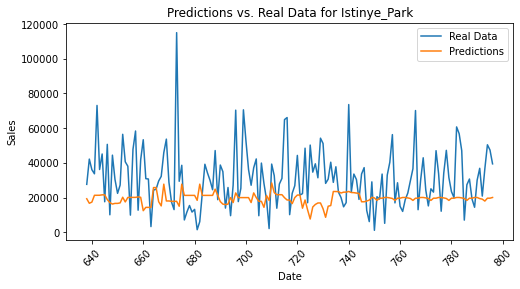

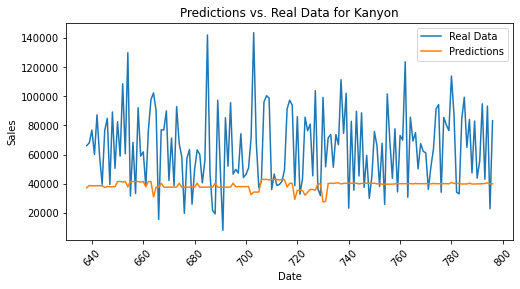

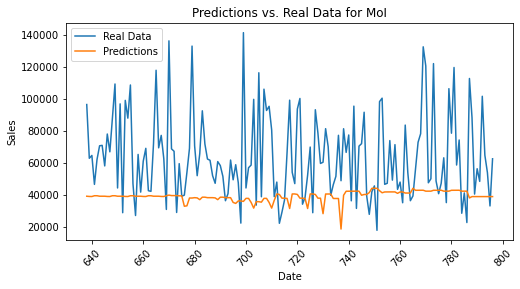

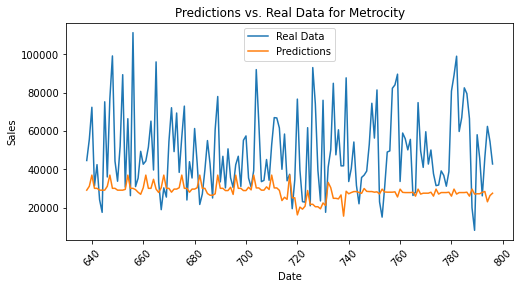

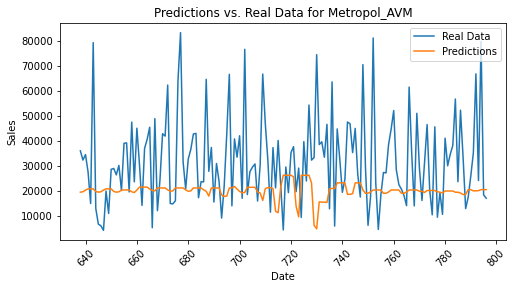

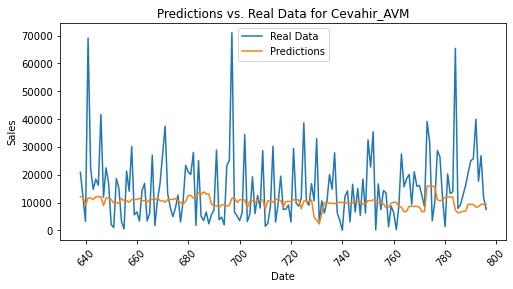

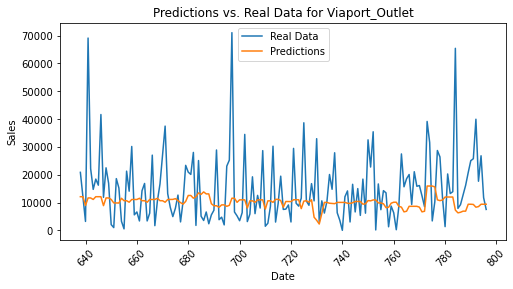

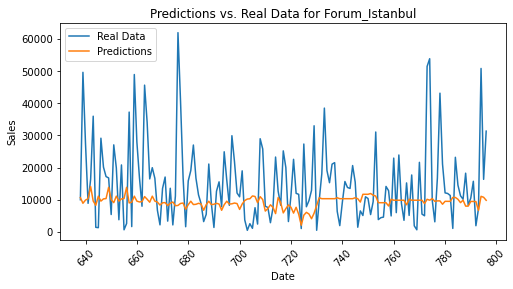

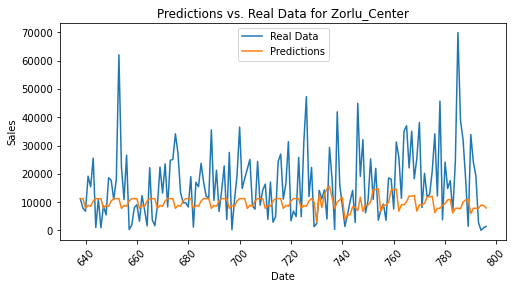

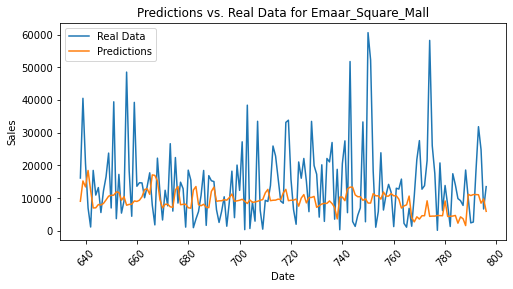

In [146]:
# Plot real test data and prediction
for y_test, y_pred, mall_name in all_predictions:
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.index, y_test['sales'], label='Real Data')
    plt.plot(y_test.index, y_pred, label='Predictions')
    plt.title(f"Predictions vs. Real Data for {mall_name}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

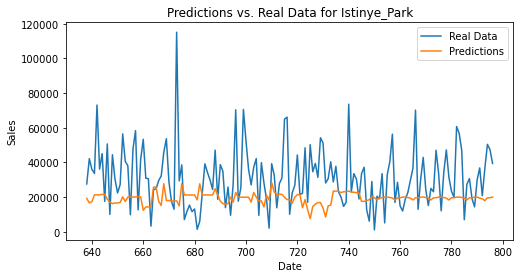

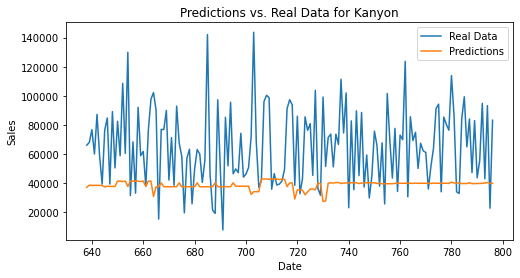

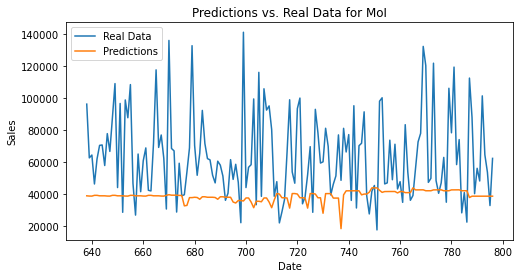

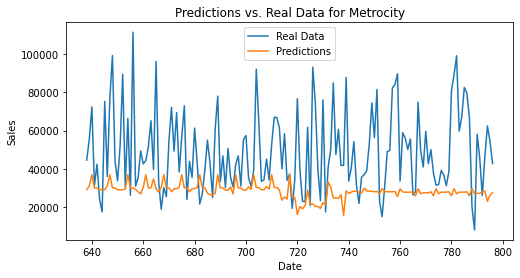

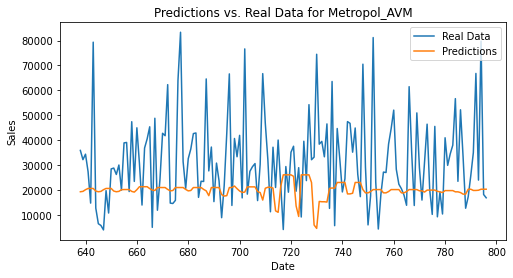

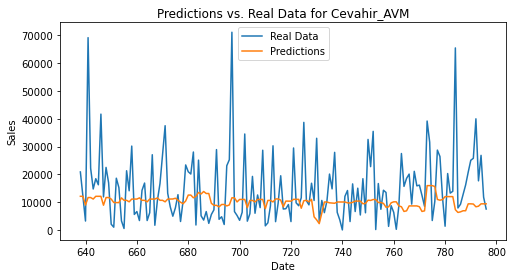

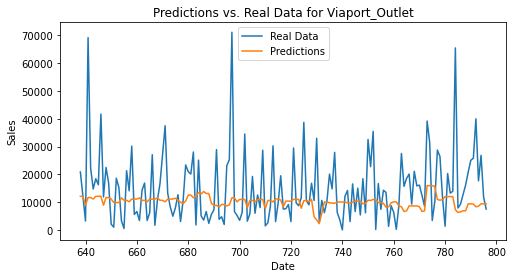

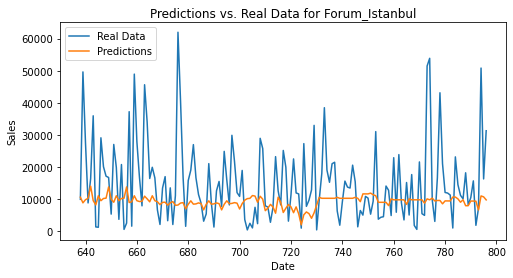

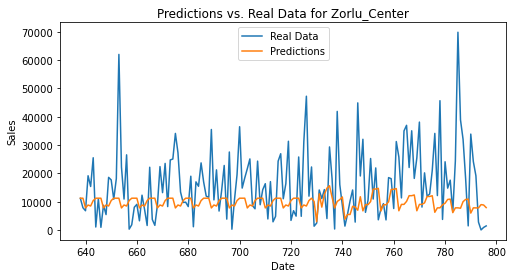

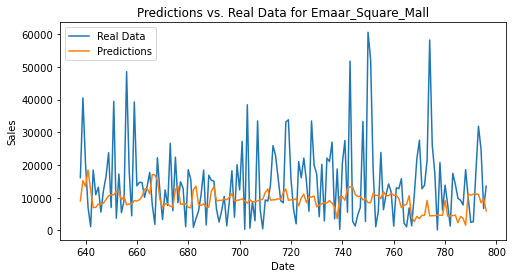

In [147]:
for y_test, y_pred, mall_name in all_predictions:
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.index, y_test['sales'], label='Real Data')
    plt.plot(y_test.index, y_pred, label='Predictions')
    plt.title(f"Predictions vs. Real Data for {mall_name}")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Istinye_Park: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Kanyon: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for MoI: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Metrocity: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Metropol_AVM: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Cevahir_AVM: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Viaport_Outlet: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Forum_Istanbul: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Zorlu_Center: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}


/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be 

Best hyperparameters for Emaar_Square_Mall: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}


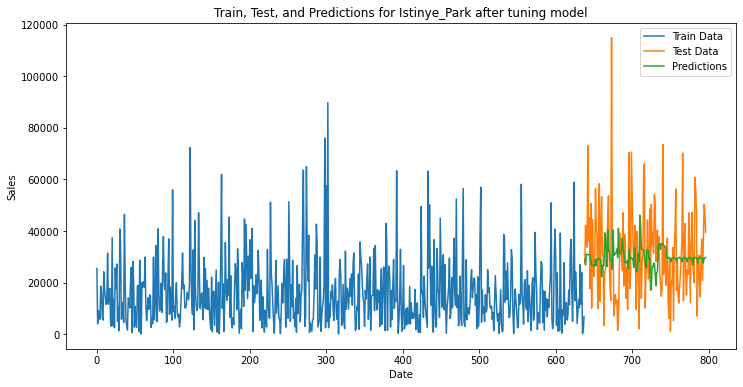

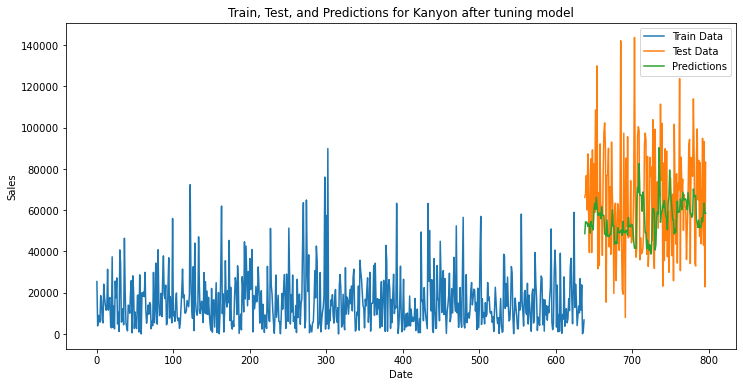

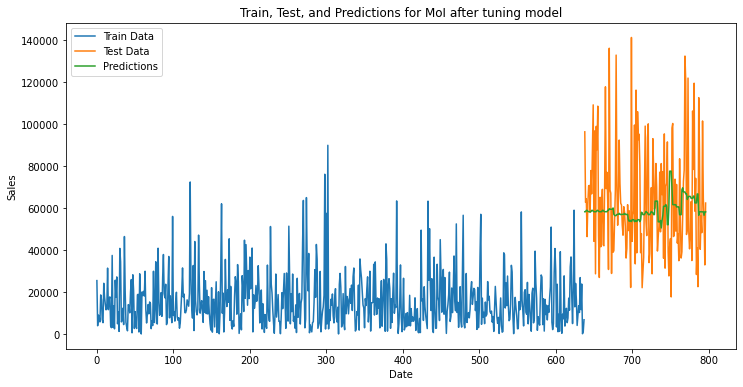

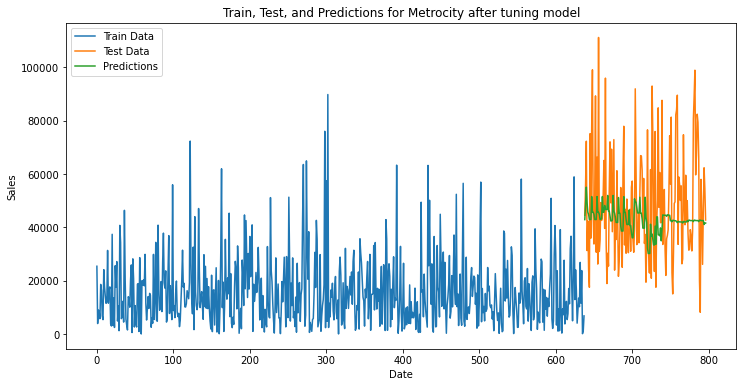

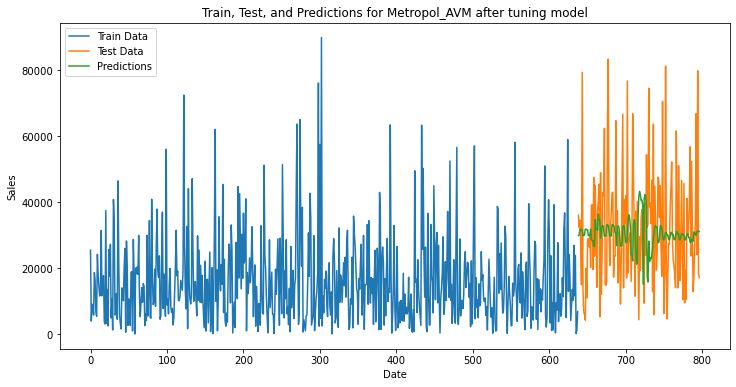

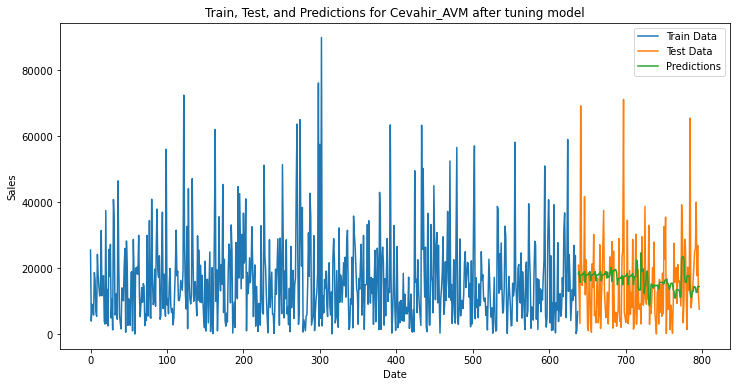

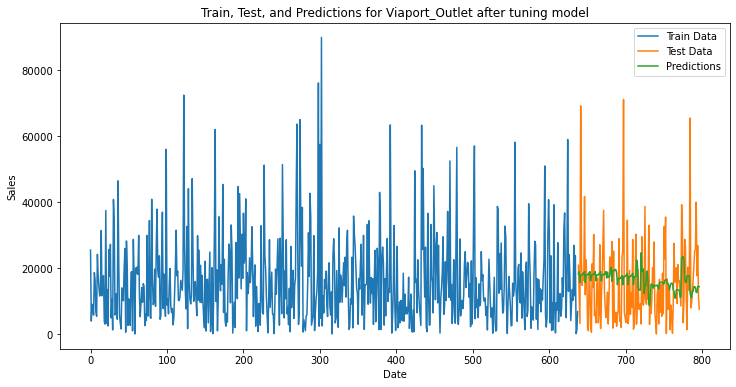

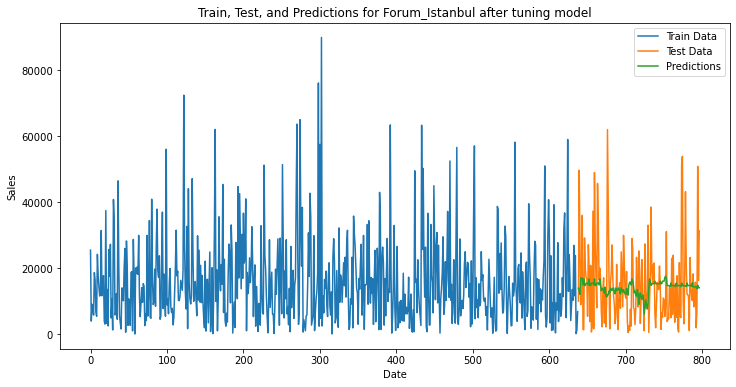

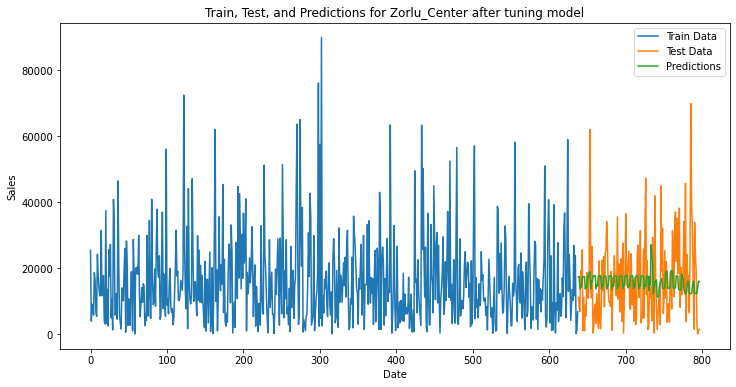

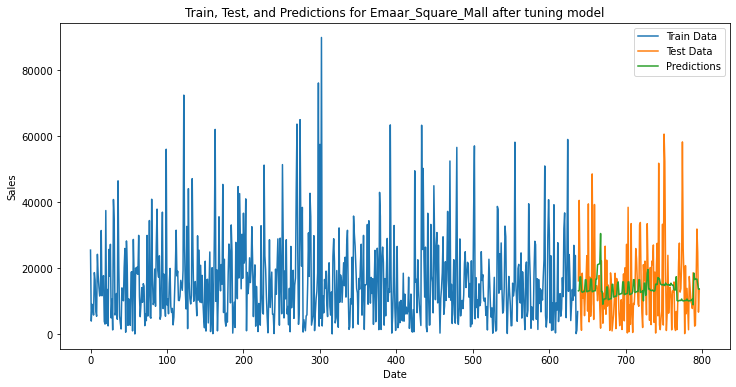

RMSE for Istinye_Park: 17633.12347514213
RMSE for Kanyon: 28889.41859714446
RMSE for MoI: 27503.554045965422
RMSE for Metrocity: 21567.794813291333
RMSE for Metropol_AVM: 18301.2407102591
RMSE for Cevahir_AVM: 12746.421753108472
RMSE for Viaport_Outlet: 12746.421753108472
RMSE for Forum_Istanbul: 12365.059486626978
RMSE for Zorlu_Center: 12713.077941436171
RMSE for Emaar_Square_Mall: 12184.33036329754


In [148]:
# List of dataset names
malls = ["Istinye_Park", "Kanyon", "MoI", "Metrocity", "Metropol_AVM", 
         "Cevahir_AVM", "Viaport_Outlet", "Forum_Istanbul", "Zorlu_Center", "Emaar_Square_Mall"]

# Function to create features (replace this with your actual feature creation function)
def create_feature(df):
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])  # Convert the invoice_date column to datetime
    df['dayofweek'] = df['invoice_date'].dt.dayofweek
    df['quarter'] = df['invoice_date'].dt.quarter
    df['month'] = df['invoice_date'].dt.month
    df['year'] = df['invoice_date'].dt.year
    df['dayofyear'] = df['invoice_date'].dt.dayofyear
    return df

# Create empty lists to store RMSE values and predictions
rmse_values = []
all_predictions = []

# Loop through each mall dataset
for mall_name in malls:
    # Load the dataset (replace 'mall_data.csv' with the actual dataset file name)
    mall_data = pd.read_csv(f"{mall_name}.csv")  # Assuming data is in CSV format
    
    # Create features (replace with your feature creation function)
    mall_data = create_feature(mall_data)
    
    # Train/Test split
    train = mall_data[mall_data['invoice_date'] < '2022-10-01']
    test = mall_data[mall_data['invoice_date'] >= '2022-10-01']
    
    # Define features and target
    features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
    target = ['sales']
    
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    
    # Initialize the XGBoost model
    reg = xgb.XGBRegressor()
    
    # Define hyperparameters to tune
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 2, 3]
    }
    
    # Perform Grid Search to find the best hyperparameters
    grid_search = GridSearchCV(reg, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from Grid Search
    best_model = grid_search.best_estimator_
    
    # Train the best model
    best_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)
    
    # Store predictions for plotting
    all_predictions.append((y_test, y_pred, mall_name))
    
    print(f"Best hyperparameters for {mall_name}: {grid_search.best_params_}")

# Plot predictions versus real data for each mall
for y_test, y_pred, mall_name in all_predictions:
    plt.figure(figsize=(12, 6))
    plt.plot(X_train.index, y_train['sales'], label='Train Data')
    plt.plot(X_test.index, y_test['sales'], label='Test Data')
    plt.plot(X_test.index, y_pred, label='Predictions')
    
    plt.title(f"Train, Test, and Predictions for {mall_name} after tuning model")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

# Print RMSE values
for mall_name, rmse in zip(malls, rmse_values):
    print(f"RMSE for {mall_name}: {rmse}")

**_Compare ARIMA, SARIMA and XGBoost model RMSE_**
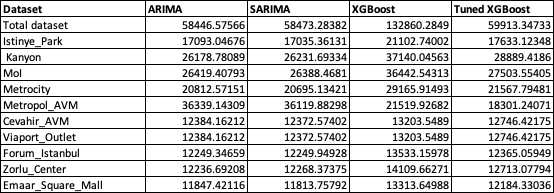

After comparing the prediction of different models, I suggest using ARIMA for this current dataset. Several factors support this recommendation:
- Lowest RMSE: ARIMA achieves the lowest Root Mean Square Error (RMSE) among the models considered, indicating its superior predictive accuracy.
- Interpretability: ARIMA and SARIMA models are more interpretable as they rely on time series components such as trend and seasonality. In contrast, XGBoost is a more complex model, making it less straightforward to explain.
- Simple model: Since there are currently no external data sources available, ARIMA remains a practical and effective choice. 

It’s also worth to mention that XGBoost has the potential to excel when coupled with external data source. Therefore, it is recommended to consider collecting a longer time series dataset and introducing exogenous features when using the XGBoost model in the future.

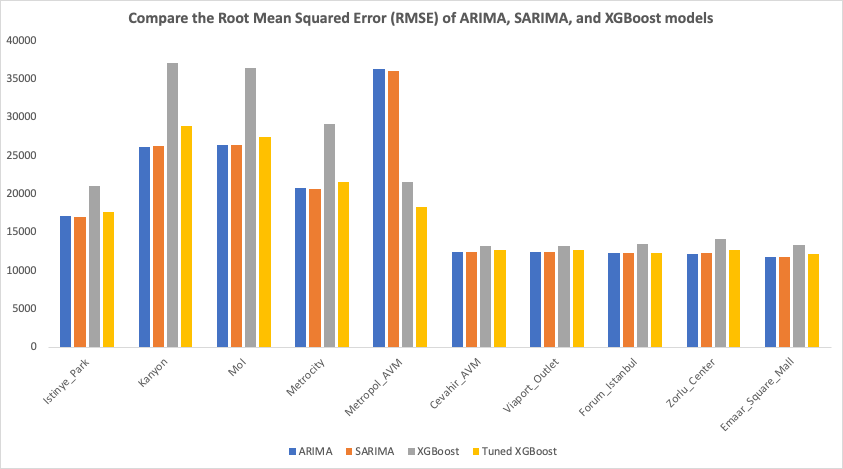
